# This File Consists of all the codes related to the model evaluation. 


In [1]:
# For use of auto arima into the model
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.8 MB/s eta 0:00:00


# 1. Reading all Necessary Libraries

In [2]:
# Setup notebook
import pandas as pd #data frame operations
import matplotlib.pyplot as plt # plotting
import numpy as np  # numercial operations
import seaborn as sns   #plotting
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess #fourier series
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import itertools
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima #auto arima model

import warnings
warnings.filterwarnings("ignore")

#Configure plot styles

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

#2. Reading the file into the Collab file

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

path = "/content/drive/MyDrive/SCM256 Supply Chain/finaldata.csv"
data = pd.read_csv(path,parse_dates=['usage_date'], date_parser=lambda x: datetime.strptime(x, '%d-%m-%Y').date())
# Dataset is now stored in a Pandas Dataframe

#if data is located separately, then please modify the data command to accomodate the same. 
#from google.colab import files
#uploaded = files.upload()
#import io
#data = pd.read_csv(io.BytesIO(uploaded['finaldata (1).csv']))

In [5]:
data

usage_date Product Family   Region Zone Region_Zone  Sold QTY  Year  \
0     2019-05-16        L1_cpus    Alpha    a     Alpha-a         0  2019   
1     2019-05-16        L1_cpus    Alpha    b     Alpha-b         0  2019   
2     2019-05-16        L1_cpus     Beta    a      Beta-a         0  2019   
3     2019-05-16        L1_cpus     Beta    b      Beta-b       400  2019   
4     2019-05-16        L1_cpus     Beta    c      Beta-c      1024  2019   
...          ...            ...      ...  ...         ...       ...   ...   
12995 2022-02-08        L1_cpus  Epsilon    b   Epsilon-b     11696  2022   
12996 2022-02-08        L1_cpus  Epsilon    d   Epsilon-d      7313  2022   
12997 2022-02-08        L1_cpus    Gamma    a     Gamma-a     62328  2022   
12998 2022-02-08        L1_cpus    Gamma    b     Gamma-b     51093  2022   
12999 2022-02-08        L1_cpus    Gamma    c     Gamma-c     14528  2022   

       Month  Weeknum Year_month Year_weeknum  serial_weeknum  serial_monthnum  
0          5       20     2019-5      2019-20              20                5  
1          5       20     2019-5      2019-20              20                5  
2          5       20     2019-5      2019-20              20                5  
3          5       20     2019-5      2019-20              20                5  
4          5       20     2019-5      2019-20              20                5  
...      ...      ...        ...          ...             ...              ...  
12995      2        7     2022-2       2022-7             166               38  
12996      2        7     2022-2       2022-7             166               38  
12997      2        7     2022-2       2022-7             166               38  
12998      2        7     2022-2       2022-7             166               38  
12999      2        7     2022-2       2022-7             166               38  

[13000 rows x 13 columns]

#3. Data Exploratory Related Codes

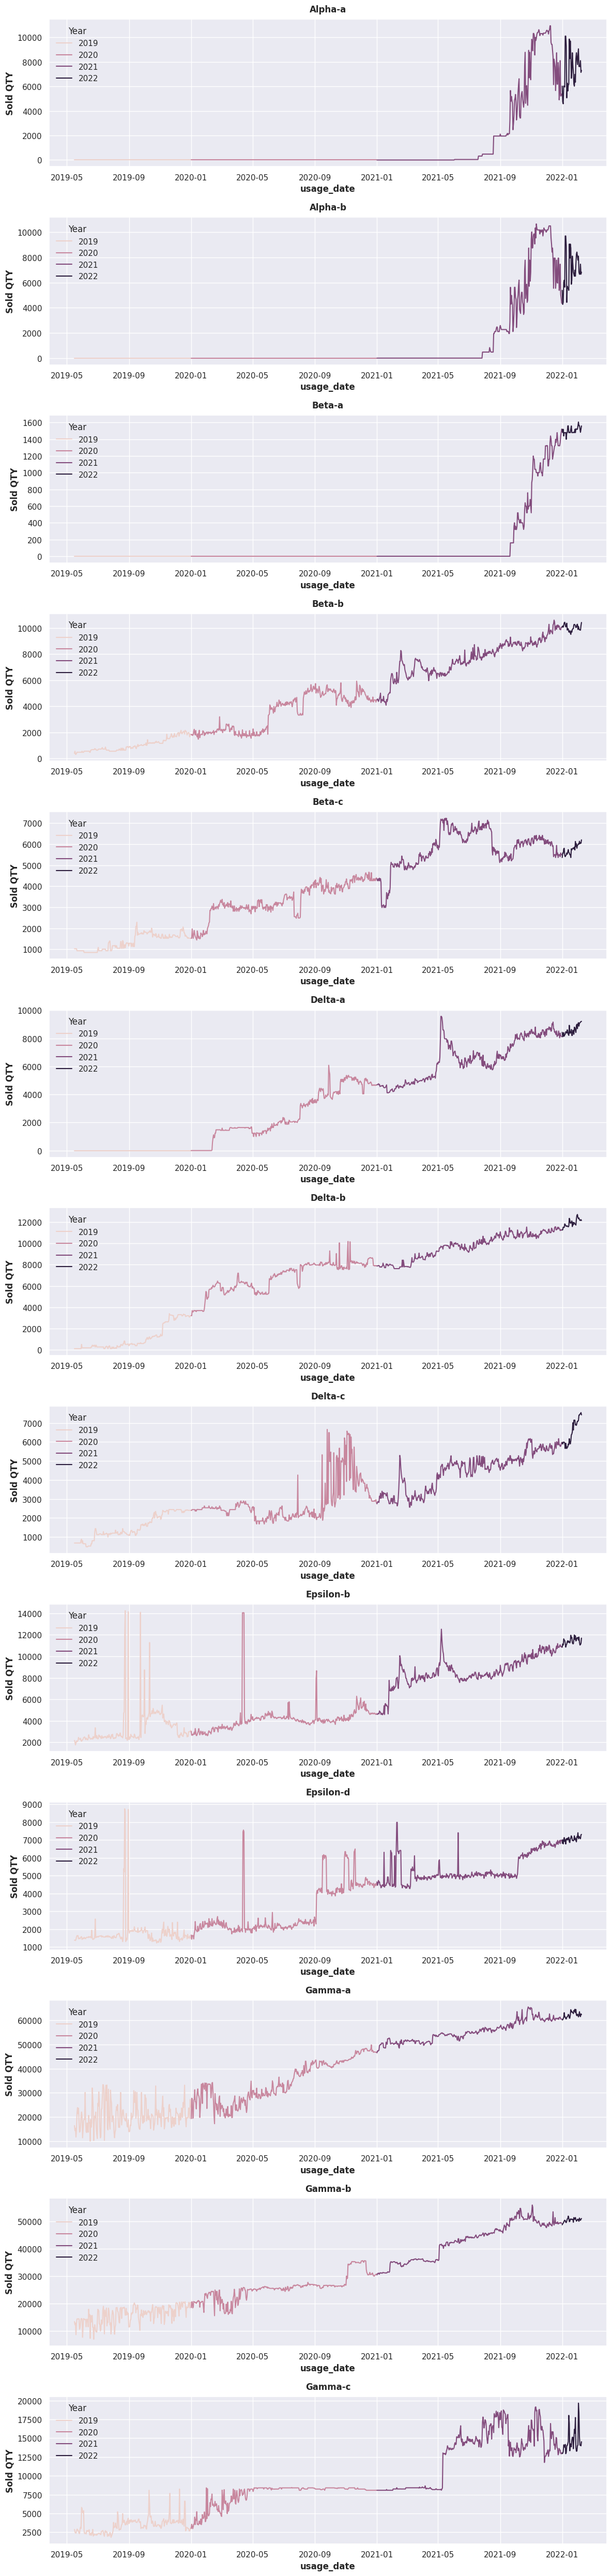

In [6]:
# Plotting each data to see how the line demand/sales look like for each product
# This is part of data explaratory purpse to see how each product region looks data looks like. 
sns.set(rc={'figure.figsize':(12,50)})

#fig, axs = plt.subplots(nrows=int((data.Store.nunique()/4)+1),ncols=4)
fig, ax = plt.subplots(data.Region_Zone.nunique())

for i, store in enumerate(data.Region_Zone.unique()):
    sns.lineplot(data=data[data.Region_Zone == store],x='usage_date',y='Sold QTY',hue='Year',ax=ax[i]).set(title = store)
    

In [7]:
#creating small dataset only with necessary columns of usage date, region zone and sold qty
small_data = data[['usage_date', 'Region_Zone', 'Sold QTY']]
#Sortting based on Region Zone, this will help us into making smaller data frame
small_data.sort_values(by='Region_Zone',ignore_index=True)

usage_date Region_Zone  Sold QTY
0     2019-05-16     Alpha-a         0
1     2021-01-24     Alpha-a         0
2     2021-01-25     Alpha-a         0
3     2019-09-29     Alpha-a         0
4     2021-01-26     Alpha-a         0
...          ...         ...       ...
12995 2021-01-17     Gamma-c      8080
12996 2021-01-16     Gamma-c      8080
12997 2021-01-15     Gamma-c      8080
12998 2021-01-27     Gamma-c      8080
12999 2022-02-08     Gamma-c     14528

[13000 rows x 3 columns]

In [8]:
#groupding by usage date and region zone. 
final = small_data.groupby(['usage_date', 'Region_Zone'])['Sold QTY'].sum().unstack()
draft = final.copy()
#Calculating the net sum across dates and product models
draft['net'] = draft.sum(axis=1)

In [9]:
draft.reset_index(inplace=True)

In [10]:
draft # each region zone is made into a column. Whereever data is not available, the data is made as 0

Region_Zone usage_date  Alpha-a  Alpha-b  Beta-a  Beta-b  Beta-c  Delta-a  \
0           2019-05-16        0        0       0     400    1024        0   
1           2019-05-17        0        0       0     560    1024        0   
2           2019-05-18        0        0       0     320    1024        0   
3           2019-05-19        0        0       0     320    1024        0   
4           2019-05-20        0        0       0     400    1024        0   
..                 ...      ...      ...     ...     ...     ...      ...   
995         2022-02-04     7624     6672    1564    9865    6144     9070   
996         2022-02-05     7624     6672    1525    9867    6024     9119   
997         2022-02-06     8104     7472    1484    9840    6064     9150   
998         2022-02-07     7144     6672    1522   10176    6048     9197   
999         2022-02-08     7304     6832    1560   10432    6209     9210   

Region_Zone  Delta-b  Delta-c  Epsilon-b  Epsilon-d  Gamma-a  Gamma-b  \
0                120      680       2168       1376    16464    13400   
1                120      680       2008       1376    14388    12250   
2                120      680       1752       1359    15392    12880   
3                120      680       1912       1416    11731     8634   
4                120      680       2128       1552    15040    12741   
..               ...      ...        ...        ...      ...      ...   
995            12237     7418      11304       7175    63542    51273   
996            12157     7475      11053       7088    61816    50624   
997            12157     7495      11088       7073    61511    50441   
998            12232     7552      11209       7288    62662    50851   
999            12153     7432      11696       7313    62328    51093   

Region_Zone  Gamma-c     net  
0               2880   38512  
1               2560   34966  
2               2400   35927  
3               2383   28220  
4               2640   36325  
..               ...     ...  
995            15157  209045  
996            14065  205109  
997            14048  205927  
998            13984  206537  
999            14528  208090  

[1000 rows x 15 columns]

In [11]:
# Plot to produce the periodogram

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [12]:
# Function to plot lags

def plot_lags(x,
              y=None,
              lags=6,
              leads=None,
              nrows=1,
              lagplot_kwargs={},
              **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault('ncols', math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    print(x,y)
    return fig

In [13]:
# Define lag plot

def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax


In [17]:
# Create a function to print periodogram, decompose both additive and multiplicative, 
# and using the linear regression based deseasonlize to find the residuals and then check for any ACF or PCF

def deseasonality(df):

  print(df.columns[1]) # Name of product region
  df['usage_date'] = pd.to_datetime(df['usage_date'])
  df= df.set_index('usage_date')

  y =  df.loc[:, df.columns[0 ]].squeeze()

  fig = plt.gcf()
  fig.set_size_inches(5, 4)

  # Plotting Periodogram
  plot_periodogram( df [df.columns[0] ]);

  # Additive decomposition
  print("ADDITIVE DECOMPOSITION")
  result = seasonal_decompose(df, model='additive')
  result.plot()
  fig = plt.gcf()
  fig.set_size_inches(10, 8)
  plt.show()    
  
  # Multiplicative decomposition
  #print("MULTIPLICATIVE DECOMPOSITION")
  #result = seasonal_decompose(df, model='multiplicative')
  #result.plot()
  #fig = plt.gcf()
  #fig.set_size_inches(10, 8)
  #plt.show()     
  
  # Fourier transformation & checking for seasonality effects and getting ACF and PCF for lags as we need this input for our linear regression later for values of lags
  print("FOURIER ANALYSIS")
  
  fourier = CalendarFourier(freq='M', order=4) # what does M and order mean --> from data it takes M as month and order = 4 is 4 pairs of sin and cos in a month to make a week
  dp = DeterministicProcess(
      constant=True,
      index=y.index,
        order=1,
      seasonal=True,
      drop=True,
      additional_terms=[fourier],
      )
  X_time = dp.in_sample()

  # Next step is finding the linear regression for the fourier terms
  model = LinearRegression(fit_intercept=False)
  model.fit(X_time, y)

  # Removing the seasonal data to find teh residual data
  y_deseason = y - model.predict(X_time)
  y_deseason.name = 'Demand_unseasoned'

  ax = y_deseason.plot()
  ax.set_title("Sales (deseasonalized)");
  X_time

  # Ensuring that only necesary data is used for plotting ACF and PCF and not falling into error 
  # There is a minimum number of data required for ACF PCF. Thus Slowly there was 
  if df.shape[0] >= 500 :
      n = 450
  else :
      n = min(df.shape[0]/2-1,450)

  #Plot ACF
  sm.graphics.tsa.plot_acf( y_deseason , lags=n, alpha = 0.1) # alpha is related to CI. 
  plt.show() #1 on y shows perfect correlation and 0 stands for negative correlation. 0 means there is no correlation
  
  #Plot PCF
  plot_pacf( y_deseason , lags=n,alpha = 0.1); # 1 day only matters. this is different from acf. 

In [18]:
# Calculating for all product geographies

for i in range(1, len ( draft.columns )  ): # Use 1 to len ( draft.columns ) to get all region zones data or use 11,12 (AS example) to get specifc region zones
  
  plt.rcParams['figure.figsize'] = [10, 5] # Setting the plot size so that all plots are same size
  sub_df = draft.loc[:, ['usage_date', draft.columns[i]]]
  deseasonality(sub_df)

Output hidden; open in https://colab.research.google.com to view.

#4. Model Evaluations 

The model evaluation is based on the 6 models we have identified in the slides. The model is evaluated based on MAPE and train:test ratio is 80:20 . 

We have not considered the cross validation in the model evaluation section. 
However once the best model is selected we will use all necessary modelling parameters

#4.1 Linear Regression of Fourier Terms (Lags)
 We have used a function to define the model and used a for loop to call the function for each region zone

In [19]:
# Predictions using Fourier and Lags. 

# For prediction making lags
def make_lags(ts, lags, lag_time=1, name='y'):
    return pd.concat(
        {f'{name}_lag_{i}': ts.shift(i)
         for i in range(lag_time, lags + lag_time)},
        axis=1)

# create dataframe with n='leads' leads with 'lead_time' and prefixed by 'name'
def make_leads(ts, leads, lead_time=1, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(lead_time, leads+lead_time))},
        axis=1)

#Making fourier transofrms 
def fourier(df):
  #fourier transformation
  #print("FOURIER ANALYSIS")
  y =  df.loc[:, df.columns[0]].squeeze()
  fourier = CalendarFourier(freq='D', order=7) # Unit of frequncey is set to replicate Daily data with weekly seasonality
  dp = DeterministicProcess(
      constant=True,
      index=y.index,
      order=1,
      seasonal=True,
      drop=True,
      additional_terms=[fourier],
      )
  return dp.in_sample()

In [20]:
# Function used for forecasting. 
# The input is a data frame with date and sold qty for each region zone 

def forecasting(df):
  
  print(df.columns[1]) #Printing the product / region one name

  df['usage_date'] = pd.to_datetime(df['usage_date'])
  df= df.set_index('usage_date')
  df= df[df[df.columns[0]] != 0]

  #Defining y
  y =  df.loc[:, df.columns[0]].squeeze()

  #Get foureir data table
  X_time = fourier(df)
  
  #Get Seasonal data using linear regression on fourier terms
  model = LinearRegression(fit_intercept=False)
  model.fit(X_time, y)

  # Finding deseadonal data by removing the linear regression of fourier terms
  y_deseason = y - model.predict(X_time)
  y_deseason.name = 'Demand_unseasoned'
  
  # Get lags data
  X_lags = make_lags(y_deseason, lags=2, name='y_1_deseason') #lag data came from the ACF,PCF plots above
  
  # Combing lags, deseaasonal data into one dataframe
  M = pd.concat([y_deseason,X_lags],axis=1).dropna()
  M['gap'] = M['y_1_deseason_lag_2'] - M['Demand_unseasoned']

  # Check for stationarity for residual data to ensure that p value <= 0 
  print("Deseasoned data with lag 2 test value")
  ad_fuller_result = adfuller(M['gap'])
  print(f'ADF Statistic: {ad_fuller_result[0]}')
  print(f'p-value: {ad_fuller_result[1]}')

  # Getting X and Y ready
  X = pd.concat([X_time, X_lags], axis=1).dropna()
  y, X = y.align(X, join='inner')

  # Splitting X and Y into training and testing data (20% is testing)
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

  # Create linear regression of X train and Y train
  model = LinearRegression(fit_intercept=False).fit(X_train, y_train)

  # Predicting on the data
  y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0) #.clip(0.0) removes negative values
  y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0) #.clip(0.0) removes negative values

  # Do MAPE and RMSE on the data and print it
  rmse_train = mean_squared_error(y_train, y_fit, squared=False) 
  rmse_valid = mean_squared_error(y_valid, y_pred, squared=False) 
  print(f'Training RMSE: {rmse_train:.5f}')
  print(f'Validation RMSE: {rmse_valid:.5f}')

  mape_train = mean_absolute_percentage_error(y_train, y_fit)
  mape_valid = mean_absolute_percentage_error(y_valid, y_pred)
  print(f'Training MAPE: {mape_train:.5f}')
  print(f'Validation MAPE: {mape_valid:.5f}')

  # plot train , test and the predictions
  ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
  ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
  ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
  
  ax.legend();



Alpha-a
Deseasoned data with lag 2 test value
ADF Statistic: -3.8600740007641683
p-value: 0.0023491403647451343
Training RMSE: 702.67768
Validation RMSE: 1473.80691
Training MAPE: 0.69680
Validation MAPE: 0.16552


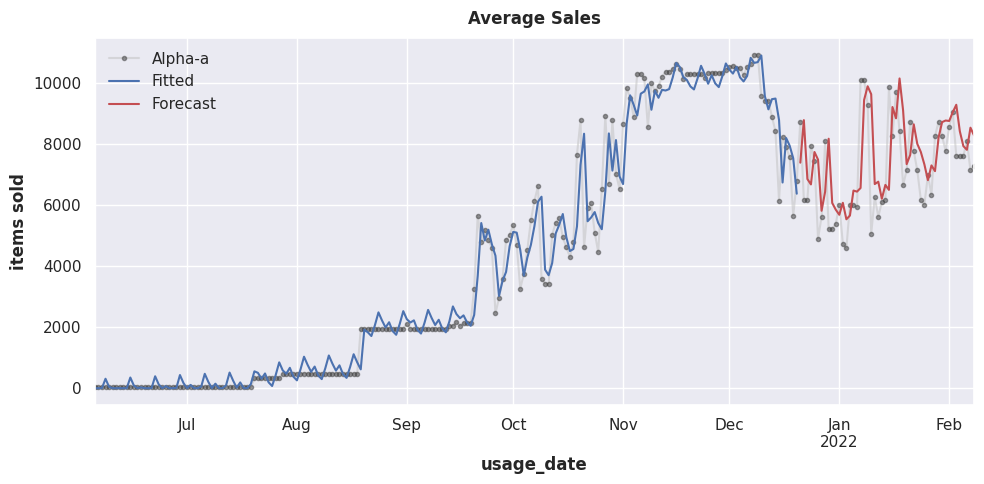

Alpha-b
Deseasoned data with lag 2 test value
ADF Statistic: -5.595109890719888
p-value: 1.3023907521340175e-06
Training RMSE: 887.41067
Validation RMSE: 1404.51768
Training MAPE: 0.20613
Validation MAPE: 0.14118


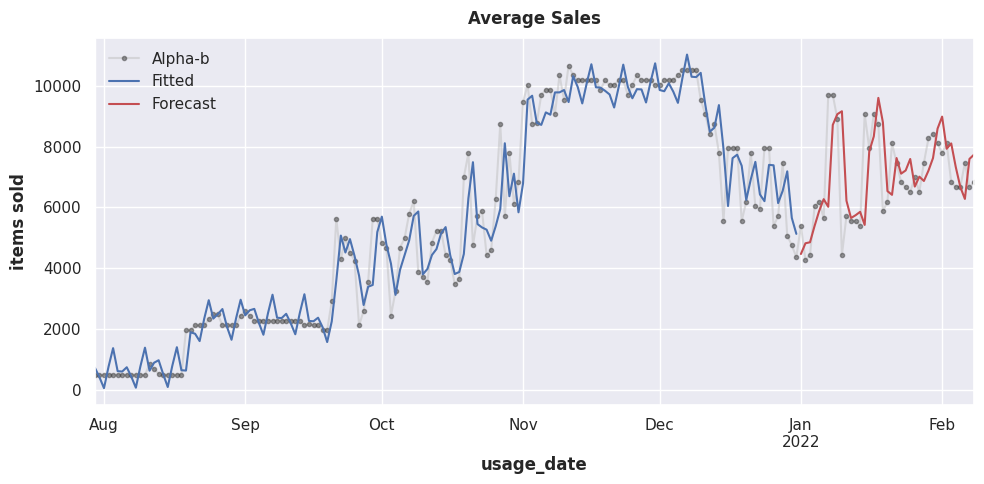

Beta-a
Deseasoned data with lag 2 test value
ADF Statistic: -6.10717994191933
p-value: 9.522562053036946e-08
Training RMSE: 71.95399
Validation RMSE: 67.21603
Training MAPE: 0.07118
Validation MAPE: 0.03868


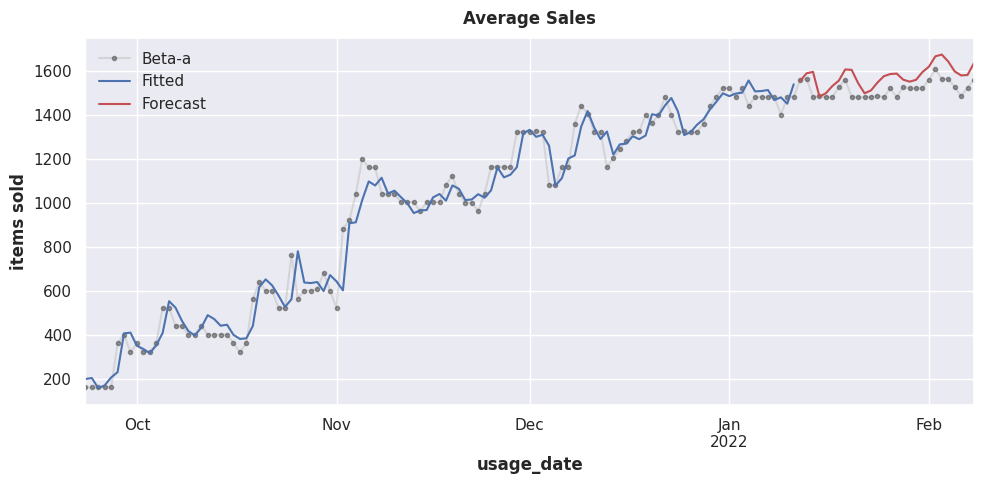

Beta-b
Deseasoned data with lag 2 test value
ADF Statistic: -8.746939720562454
p-value: 2.9055757165231945e-14
Training RMSE: 233.06846
Validation RMSE: 201.05421
Training MAPE: 0.05450
Validation MAPE: 0.01734


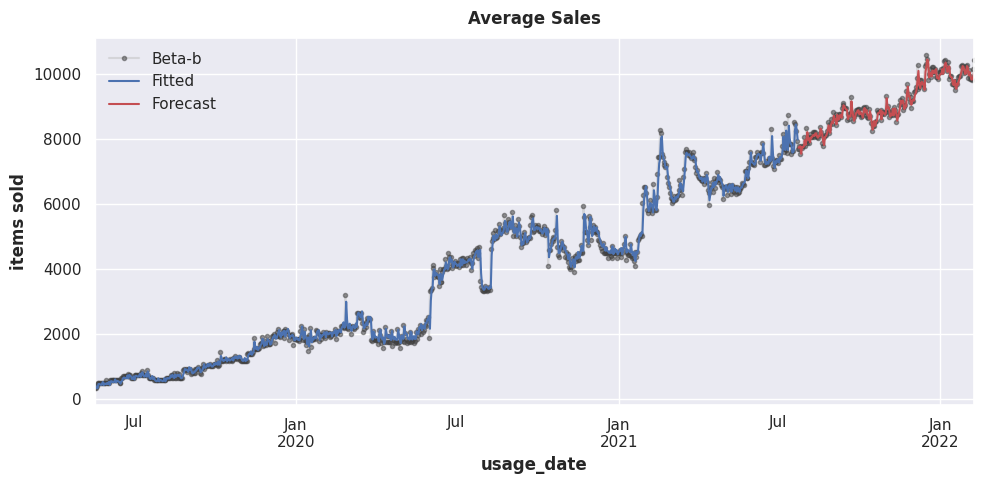

Beta-c
Deseasoned data with lag 2 test value
ADF Statistic: -9.664367932764604
p-value: 1.3273284005709146e-16
Training RMSE: 161.26468
Validation RMSE: 175.49124
Training MAPE: 0.03704
Validation MAPE: 0.02270


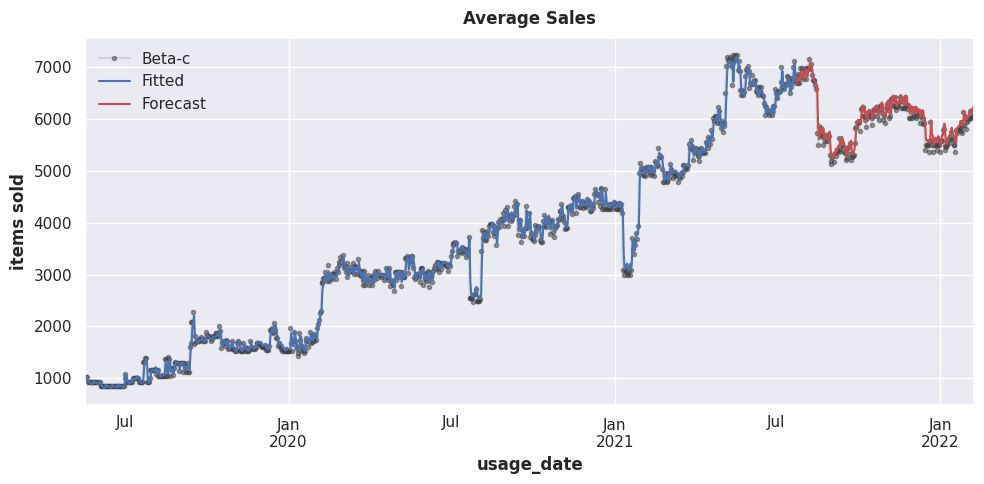

Delta-a
Deseasoned data with lag 2 test value
ADF Statistic: -7.655501788841356
p-value: 1.7434360970565756e-11
Training RMSE: 226.10859
Validation RMSE: 233.70164
Training MAPE: 0.03586
Validation MAPE: 0.02191


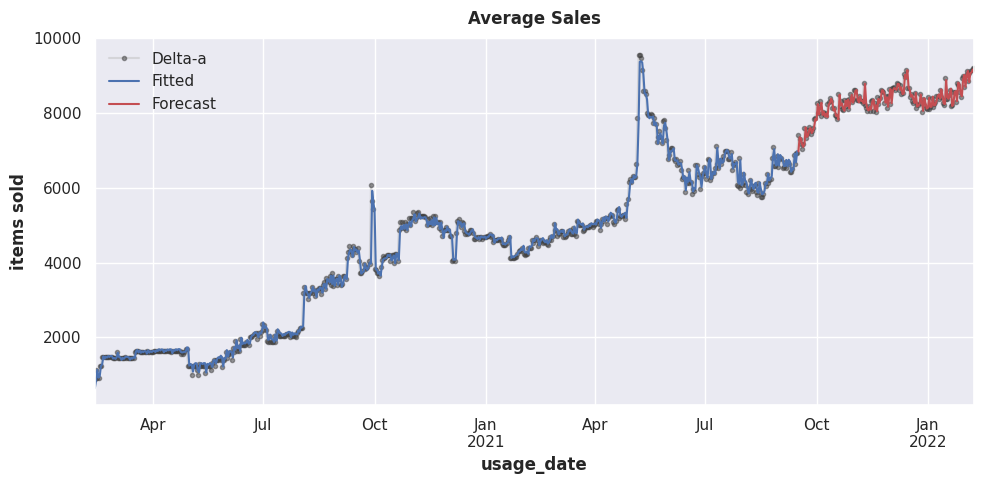

Delta-b
Deseasoned data with lag 2 test value
ADF Statistic: -6.897965000729138
p-value: 1.304064596387507e-09
Training RMSE: 273.97537
Validation RMSE: 224.59426
Training MAPE: 0.06746
Validation MAPE: 0.01518


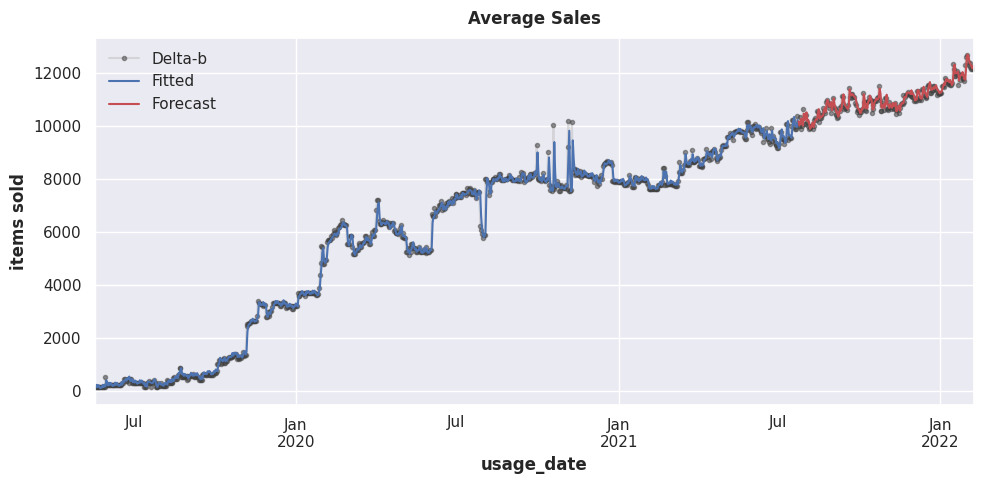

Delta-c
Deseasoned data with lag 2 test value
ADF Statistic: -7.514426708082691
p-value: 3.93744590914549e-11
Training RMSE: 451.84410
Validation RMSE: 236.73364
Training MAPE: 0.07637
Validation MAPE: 0.03275


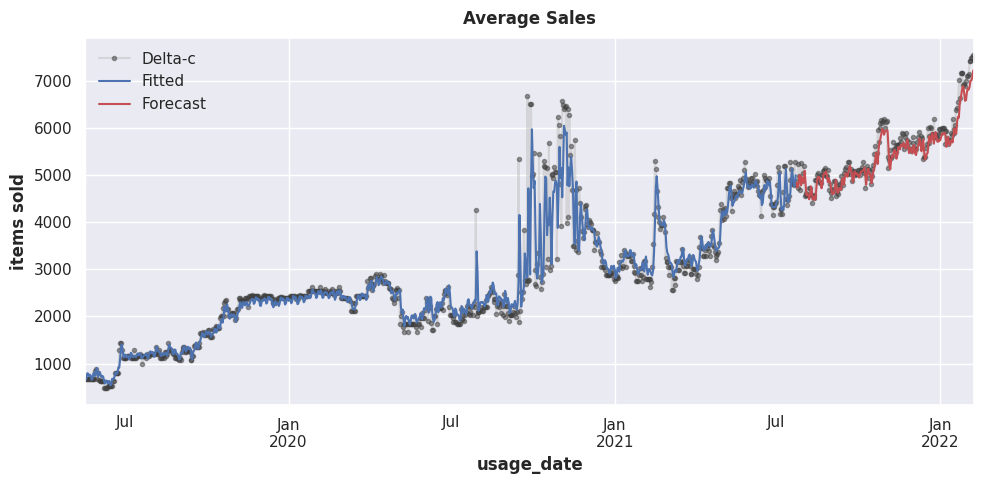

Epsilon-b
Deseasoned data with lag 2 test value
ADF Statistic: -8.388198990543739
p-value: 2.4062099276552896e-13
Training RMSE: 1097.67133
Validation RMSE: 461.46515
Training MAPE: 0.09313
Validation MAPE: 0.03654


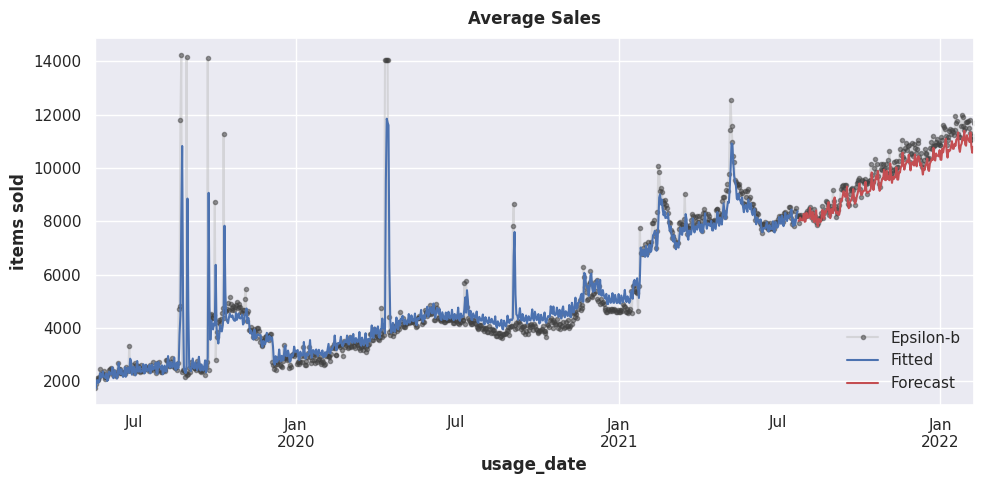

Epsilon-d
Deseasoned data with lag 2 test value
ADF Statistic: -9.348619690636793
p-value: 8.413080004450778e-16
Training RMSE: 599.88155
Validation RMSE: 180.86719
Training MAPE: 0.09181
Validation MAPE: 0.02519


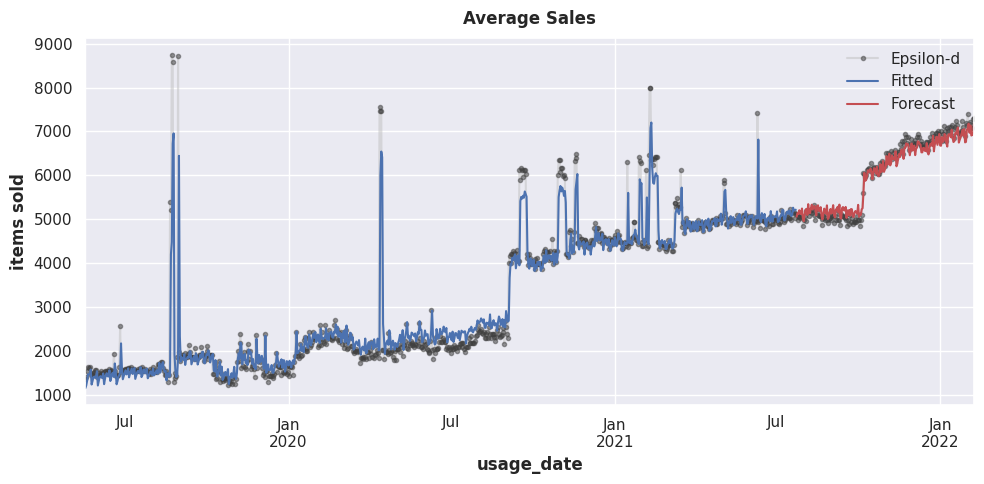

Gamma-a
Deseasoned data with lag 2 test value
ADF Statistic: -7.645594093469959
p-value: 1.8463444996053765e-11
Training RMSE: 2838.70295
Validation RMSE: 1261.59449
Training MAPE: 0.07451
Validation MAPE: 0.01686


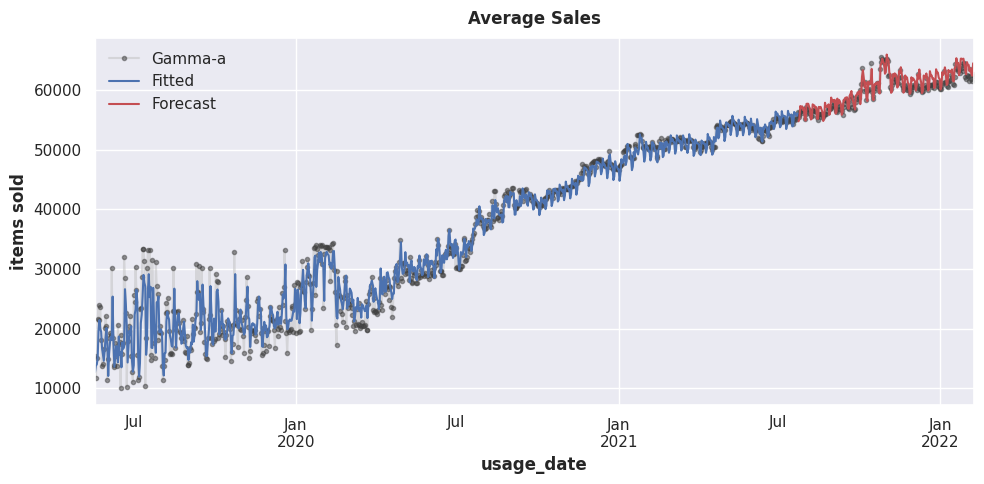

Gamma-b
Deseasoned data with lag 2 test value
ADF Statistic: -6.7199663248155215
p-value: 3.5033072892560305e-09
Training RMSE: 1453.86920
Validation RMSE: 1169.10837
Training MAPE: 0.05145
Validation MAPE: 0.01736


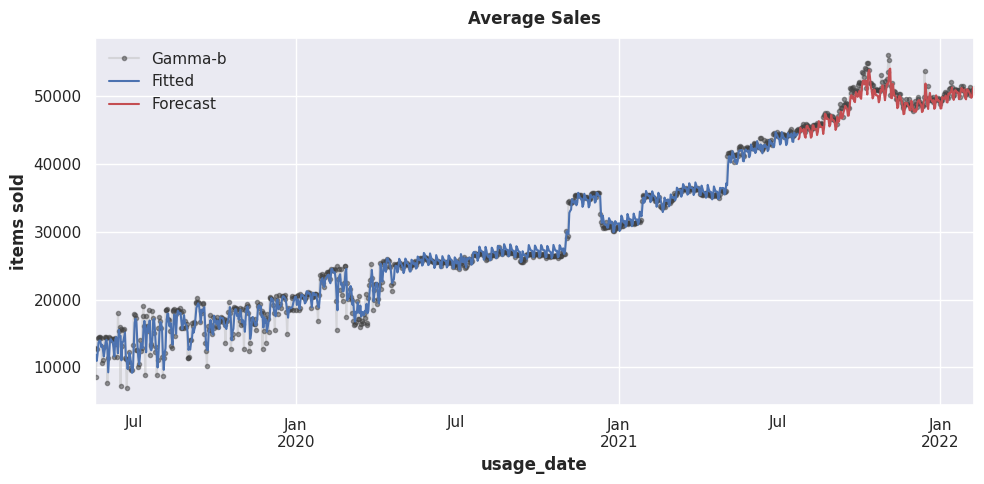

Gamma-c
Deseasoned data with lag 2 test value
ADF Statistic: -7.778541496610281
p-value: 8.539242317531661e-12
Training RMSE: 571.93526
Validation RMSE: 1185.07229
Training MAPE: 0.05336
Validation MAPE: 0.05050


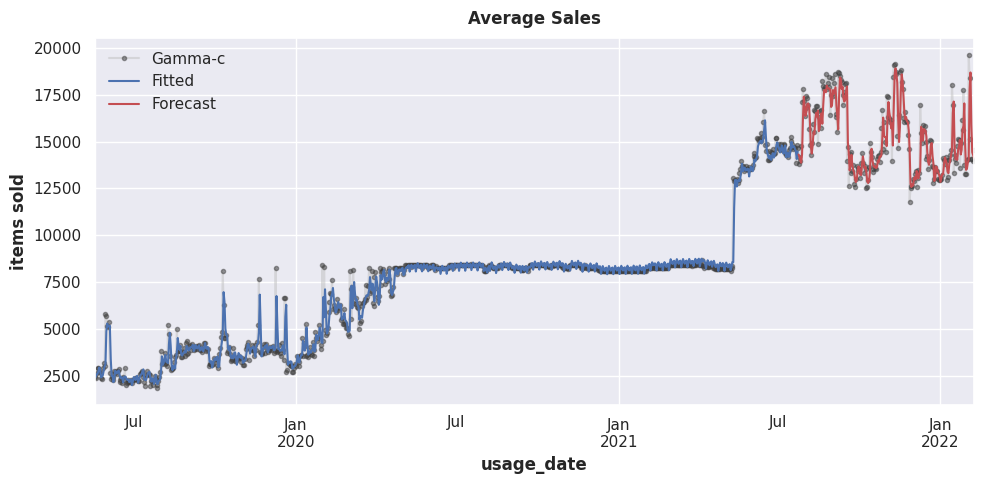

net
Deseasoned data with lag 2 test value
ADF Statistic: -6.879990474780064
p-value: 1.4416580588852116e-09
Training RMSE: 4288.85335
Validation RMSE: 4591.15364
Training MAPE: 0.04641
Validation MAPE: 0.01938


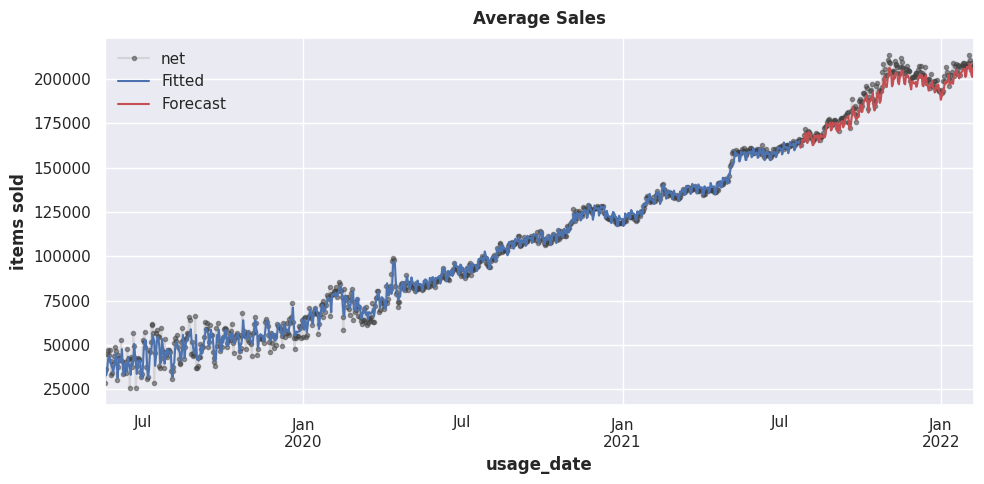

In [21]:
# Calculating for all product geographies

for i in range(1, len ( draft.columns )  ): # Use 1 to len ( draft.columns ) to get all region zones data or use 11,12 (AS example) to get specifc region zones
    
    plt.rcParams['figure.figsize'] = [10, 5]
    sub_df = draft.loc[:, ['usage_date', draft.columns[i]]]
    forecasting(sub_df)
    plt.show()

# 4.2 SARIMA and 4.3 Auto ARIMA Model

In [22]:
# SARIMA Module

def  sarima_daily(df):
  #print(df)
  s = df.columns[1]
  print(s) 

  df['usage_date'] = pd.to_datetime(df['usage_date'])
  df['year'] = df['usage_date'].dt.year
  df['month'] = df['usage_date'].dt.month
  df['week'] = df['usage_date'].dt.week
  df['day'] = df['usage_date'].dt.day
  df['weekday'] = df['usage_date'].dt.weekday
  
  df= df.set_index('usage_date')
  df= df[df[df.columns[0]] != 0]
  
  # Creating Y values 
  y =  pd.DataFrame(df[df.columns[0]])
    
  # Splitting train and test of y
  train,test = train_test_split(y,train_size=0.8,shuffle=False)

  #################################################################################################################################
  #AUTO ARIMA MODEL

  #Trying Auto Arima also to ensure whether another parameters emerge from the analysis
  model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=7, stepwise=True) # 7 is kept here for weekly seasonality
  model.fit(train) 

  start_index = test.index.min()
  end_index = test.index.max()

  #Predictions
  pred = model.predict()
  pred = model.predict(n_periods=len(test))
  pred = pd.DataFrame(pred,index = test.index,columns=['Prediction'])
  forecast = model.predict(n_periods=len(test))
  forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

  # report performance
  mse = mean_squared_error(y[start_index:end_index], forecast)
  mape = mean_absolute_percentage_error(y[start_index:end_index], forecast)
  rmse = mse**0.5
  print('RMSE: {}, MSE:{}, MAPE:{}'.format(rmse,mse,mape))

  #plot the predictions for validation set
  plt.plot(y,label='Train and Valid',color='C3')
  #plt.plot(valid, label='Valid')
  plt.plot(forecast , label='Prediction auto arima',color='C0')
  plt.legend();
  plt.show()
  
  
  ##################################################################################################################################
  #SARIMA parameter estimation best ones

  print("********************************* SARIMA MODEL ******************************** ")

  p = d = q = range(0, 2) # From the auto arima, we got the max values of pdqPDQ and we estimate from ACF PCF graphs
  pdq = list(itertools.product(p, d, q)) # Make all possible combinations of pdqPDQ using range mentioned above
  seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))] # Entend the same range to the PDQ as well 

  print('Examples of grid search Model parameter combinations for Seasonal-ARIMA')
  print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

  list_param = []
  list_param_seasonal=[]
  list_results_aic=[]
  
  # Finding the parameters with lowest AIC value 

  min_aic = 999999999 
  for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,                              # Calling the SARIMA model
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue
  print("MIN AIC MODEL SUMMARY : ")
  min_aic_model.summary()
  print(min_aic_model.summary())
  
  min_aic_model.plot_diagnostics(figsize=(16,10));
  plt.show()

  #Predicting with SARIMAX for Test data
  start_index = test.index.min()
  print(start_index)
  end_index = test.index.max()

  #Predictions over the test data
  predictions = min_aic_model.predict(start=start_index, end=end_index)

  # report performance over predictions and test data
  mse = mean_squared_error(y[start_index:end_index], predictions)
  mape = mean_absolute_percentage_error(y[start_index:end_index], predictions)
  rmse = mse**0.5
  print('RMSE: {}, MSE:{}, MAPE:{}'.format(rmse,mse,mape))

  plt.plot(y)
  plt.plot(predictions,label='Min AIC Model',color='C2')
  plt.title('RMSE: %.4f'% rmse) 
  plt.legend();
  plt.show()
  
  

In [23]:
# Calculating for all product geographies

for i in range(1, len ( draft.columns )  ): # Use 1 to len ( draft.columns ) to get all region zones data or use 11,12 (AS example) to get specifc region zones
    #print(i)

    sub_df = draft.loc[:, ['usage_date', draft.columns[i]]]
    sarima_daily(sub_df)

Output hidden; open in https://colab.research.google.com to view.

# 4.3 Holt Winters Model (Optimized parameters)

In [24]:
# doing holt winters model

def holt_winters(df,alpha,beta,gamma): #alpha beta gamma are values used for holt winters model as parameters
  #print(df)
  s = df.columns[1]
  print(s) 
  
  df['usage_date'] = pd.to_datetime(df['usage_date'])
  df['year'] = df['usage_date'].dt.year
  df['month'] = df['usage_date'].dt.month
  df['week'] = df['usage_date'].dt.week
  df['day'] = df['usage_date'].dt.day
  df['weekday'] = df['usage_date'].dt.weekday
  
  df= df.set_index('usage_date')
  df= df[df[df.columns[0]] != 0]
  
  y =  pd.DataFrame(df[df.columns[0]])
  
  # Train and Test data for modelling
  train,test = train_test_split(y,train_size=0.8,shuffle=False)

  # Fitting model to train data and getting fitted values to see how much the training data is correct to true train data
  y_texp = ExponentialSmoothing(train,trend = 'add',seasonal = 'add' , seasonal_periods = 7).fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma).fittedvalues
  
  # Fitting model to training data
  y_texp_model = ExponentialSmoothing(train,trend = 'add', seasonal ='add', seasonal_periods = 7 ).fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)

  # Predict for test data
  n = len(test) # length of n for prediction
  pred_sexp = y_texp_model.forecast(n)
  print("n=",n)

  # report performance
  mse = mean_squared_error(test, pred_sexp)
  mape = mean_absolute_percentage_error(test, pred_sexp)
  rmse = mse**0.5
  print('RMSE: {}, MSE:{}, MAPE:{}'.format(rmse,mse,mape))
  print('Alpha: {}, Beta:{}, Gamma:{}'.format(alpha,beta,gamma))
  
  #Plotting
  plt.plot(train,label='Train',color='C3')
  plt.plot(test , label='Test',color='green')
  plt.plot(pred_sexp , label='HW Predictions',color='blue')
  plt.plot(y_texp , label='HW Fitted data',color='orange')
  plt.legend();
  fig = plt.gcf()
  fig.set_size_inches(10, 8)#
  plt.show()


In [25]:
# This function is used to determine the best parameters for alpha beta and gamma 

def tes_optimizer(train, test, abg, step, trend_mode='add', seasonal_mode = 'add', seasonal_period=7):

    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")

    #print(train.isnull().values.any())
    #print(test.isnull().values.any())

    for comb in abg: # visit the each combination
        tes_model = ExponentialSmoothing(train, trend=trend_mode, seasonal=seasonal_mode, seasonal_periods=seasonal_period).\
            fit(smoothing_level=comb[0], smoothing_trend=comb[1], smoothing_seasonal=comb[2]) # 0: alpha, 1: beta, 2: gamma. Creates a new TES instance by using each combination
        y_pred = tes_model.forecast(step) # forecast the `step` step later by using the TES instance
        #print(test)
        #print(y_pred)
        #print(comb)
        mape = mean_absolute_percentage_error(test, y_pred) # calculate the MAE (mean absolute error)
        if mape < best_mae: # mark the best parameters
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mape
        #print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mape, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [26]:
alphas = betas = gammas = np.arange(0.10, 0.9, 0.2) # We are moving values from 0.1 0.3 0.5 0.7 0.9

In [27]:
print("Alphas: {}\nBetas: {}\nGammas: {}".format(alphas, betas, gammas))

Alphas: [0.1 0.3 0.5 0.7]
Betas: [0.1 0.3 0.5 0.7]
Gammas: [0.1 0.3 0.5 0.7]


In [28]:
# Creating a list of all possible iterations of alpha beta gamma

abg = list(itertools.product(alphas, betas, gammas))
print(abg)

[(0.1, 0.1, 0.1), (0.1, 0.1, 0.30000000000000004), (0.1, 0.1, 0.5000000000000001), (0.1, 0.1, 0.7000000000000001), (0.1, 0.30000000000000004, 0.1), (0.1, 0.30000000000000004, 0.30000000000000004), (0.1, 0.30000000000000004, 0.5000000000000001), (0.1, 0.30000000000000004, 0.7000000000000001), (0.1, 0.5000000000000001, 0.1), (0.1, 0.5000000000000001, 0.30000000000000004), (0.1, 0.5000000000000001, 0.5000000000000001), (0.1, 0.5000000000000001, 0.7000000000000001), (0.1, 0.7000000000000001, 0.1), (0.1, 0.7000000000000001, 0.30000000000000004), (0.1, 0.7000000000000001, 0.5000000000000001), (0.1, 0.7000000000000001, 0.7000000000000001), (0.30000000000000004, 0.1, 0.1), (0.30000000000000004, 0.1, 0.30000000000000004), (0.30000000000000004, 0.1, 0.5000000000000001), (0.30000000000000004, 0.1, 0.7000000000000001), (0.30000000000000004, 0.30000000000000004, 0.1), (0.30000000000000004, 0.30000000000000004, 0.30000000000000004), (0.30000000000000004, 0.30000000000000004, 0.5000000000000001), (0.

In [29]:
alpha=[]
beta=[]
gamma=[]

for i in range(1, len(draft.columns)   ): #len ( draft.columns )
    #print(i)

    sub_df = draft.loc[:, ['usage_date', draft.columns[i]]]
    sub_df= sub_df.set_index('usage_date')
    sub_df= sub_df[sub_df[sub_df.columns[0]] != 0]
    
    y =  pd.DataFrame(sub_df[sub_df.columns[0]])
    print(y.columns[0])

    #Train and Test data for modelling
    train,test = train_test_split(y,train_size=0.8,shuffle=False)

    # Finding the best alpha beta gamma values
    best_alpha, best_beta, best_gamma, best_mape = tes_optimizer(train,test, abg, len(test))
    
    # Storing all the alpha beta gamma as a list in the sequence of the region zone list
    alpha.append(best_alpha)
    beta.append(best_beta)
    gamma.append(best_gamma)


Alpha-a
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.7 best_mae: 0.4184
Alpha-b
best_alpha: 0.1 best_beta: 0.5 best_gamma: 0.1 best_mae: 0.1716
Beta-a
best_alpha: 0.1 best_beta: 0.3 best_gamma: 0.5 best_mae: 0.0206
Beta-b
best_alpha: 0.1 best_beta: 0.3 best_gamma: 0.1 best_mae: 0.0321
Beta-c
best_alpha: 0.5 best_beta: 0.3 best_gamma: 0.1 best_mae: 0.132
Delta-a
best_alpha: 0.5 best_beta: 0.5 best_gamma: 0.7 best_mae: 0.0601
Delta-b
best_alpha: 0.5 best_beta: 0.3 best_gamma: 0.1 best_mae: 0.0657
Delta-c
best_alpha: 0.5 best_beta: 0.1 best_gamma: 0.3 best_mae: 0.0805
Epsilon-b
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.1 best_mae: 0.0298
Epsilon-d
best_alpha: 0.7 best_beta: 0.3 best_gamma: 0.1 best_mae: 0.0503
Gamma-a
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.3 best_mae: 0.0187
Gamma-b
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.1 best_mae: 0.0315
Gamma-c
best_alpha: 0.1 best_beta: 0.3 best_gamma: 0.1 best_mae: 0.0969
net
best_alpha: 0.5 best_beta: 0.1 best_gamma: 0.7 best_mae: 0.0

Alpha-a
n= 51
RMSE: 3830.6433138779203, MSE:14673828.198157614, MAPE:0.4183754911453365
Alpha: 0.1, Beta:0.1, Gamma:0.7000000000000001


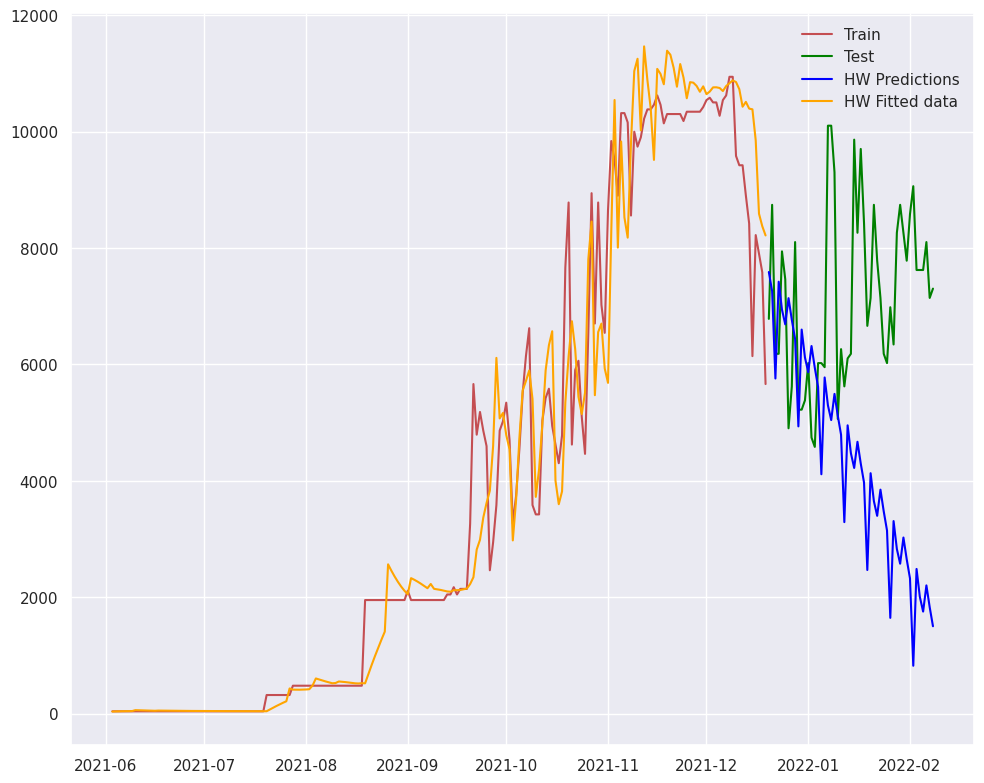

Alpha-b
n= 40
RMSE: 1700.6908895945683, MSE:2892349.5019499636, MAPE:0.1716304271166345
Alpha: 0.1, Beta:0.5000000000000001, Gamma:0.1


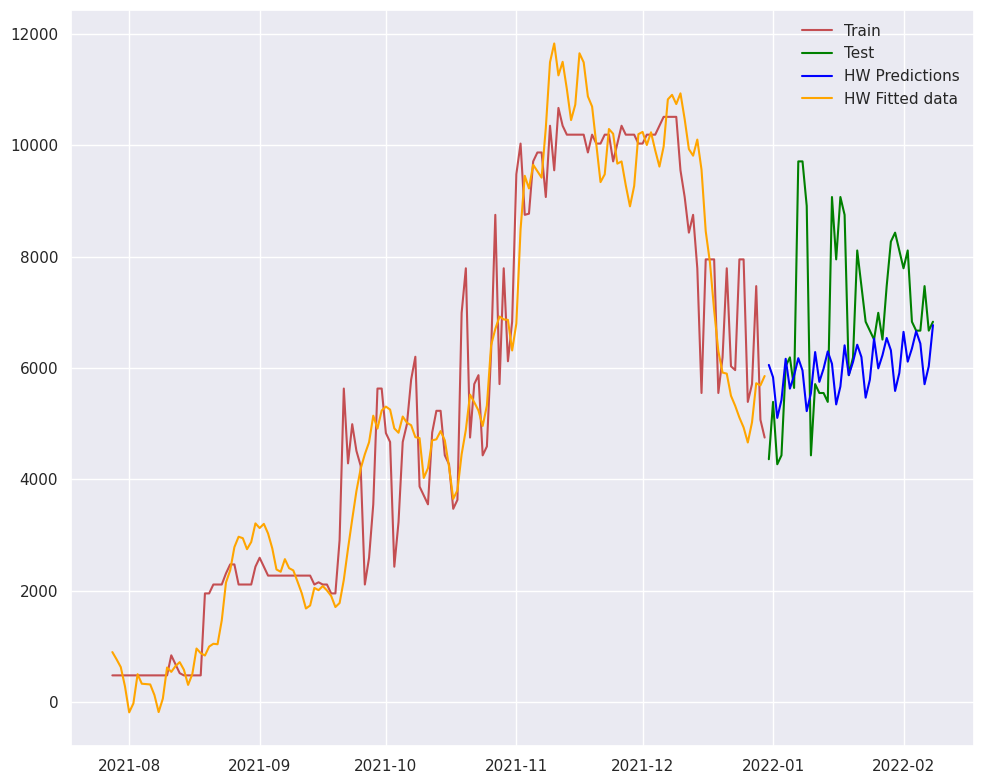

Beta-a
n= 29
RMSE: 35.28331714658956, MSE:1244.912468866821, MAPE:0.02062515272193504
Alpha: 0.1, Beta:0.30000000000000004, Gamma:0.5000000000000001


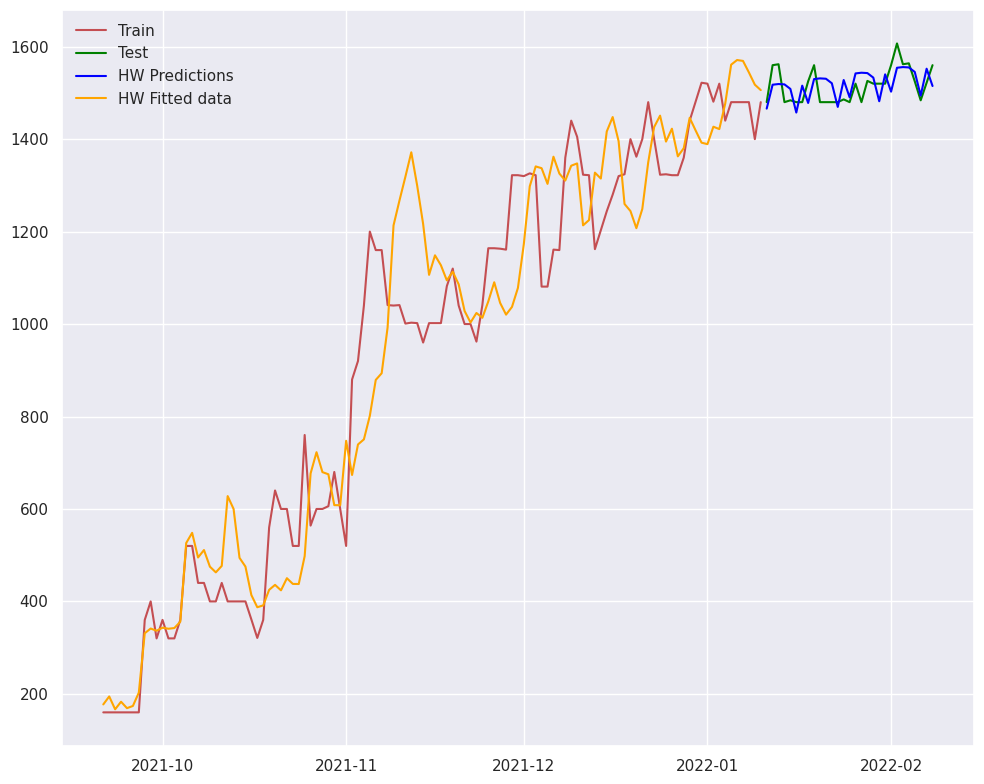

Beta-b
n= 200
RMSE: 365.25370560916406, MSE:133410.26946122586, MAPE:0.03214964499076385
Alpha: 0.1, Beta:0.30000000000000004, Gamma:0.1


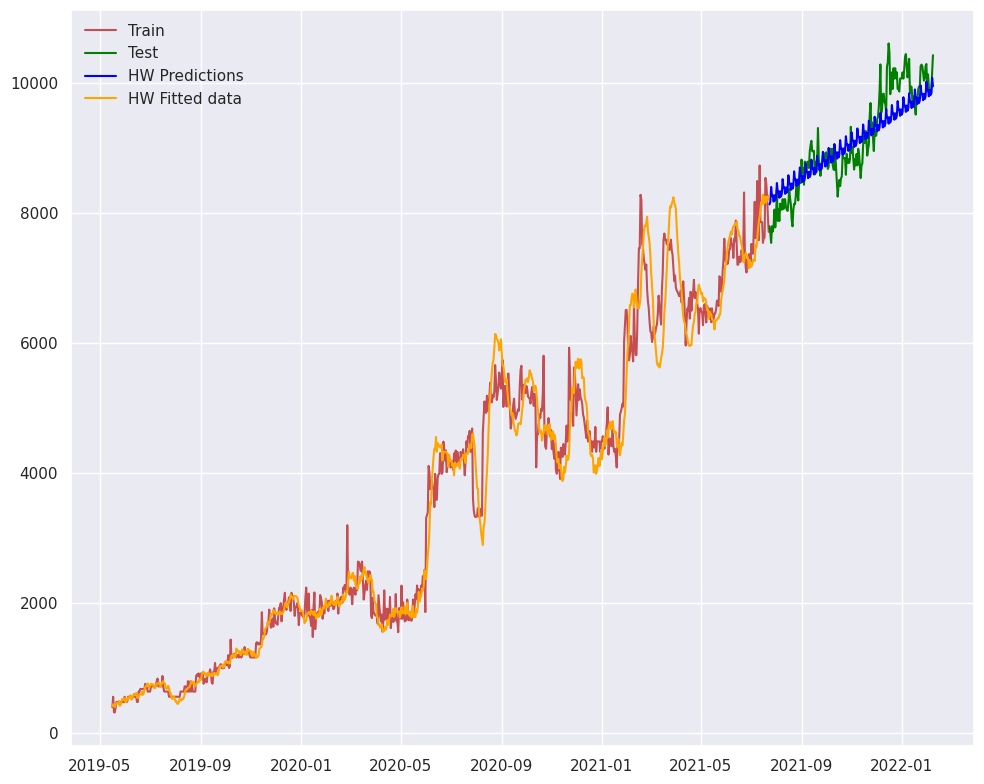

Beta-c
n= 200
RMSE: 855.7527890980449, MSE:732312.8360490829, MAPE:0.1319984267406454
Alpha: 0.5000000000000001, Beta:0.30000000000000004, Gamma:0.1


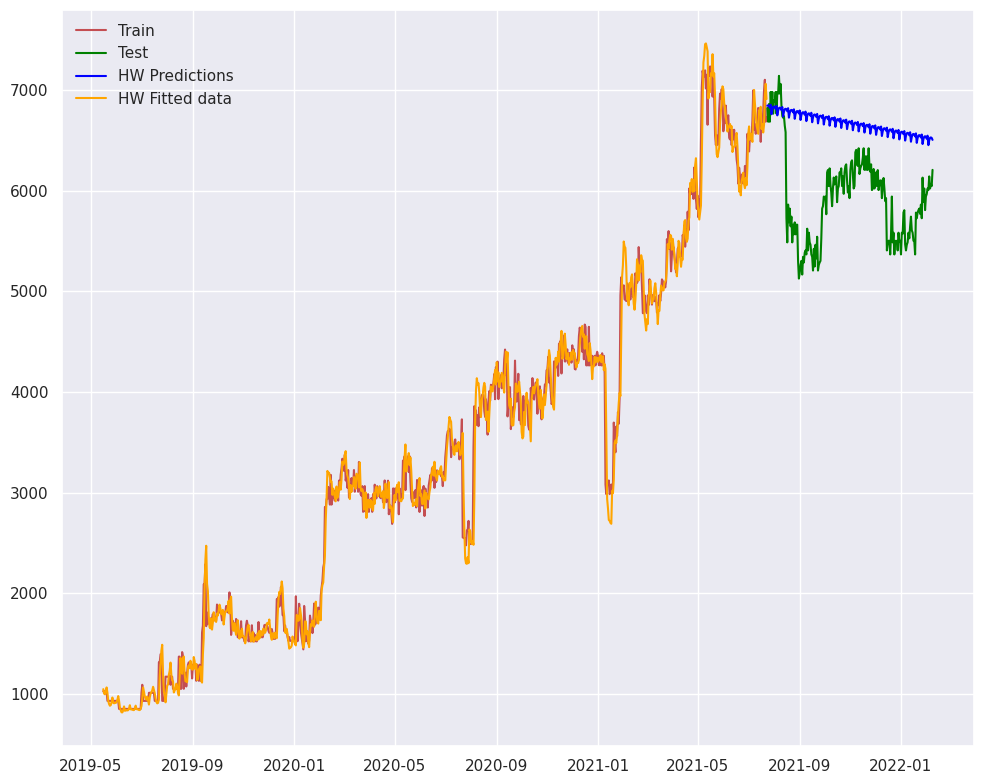

Delta-a
n= 146
RMSE: 572.518350771951, MSE:327777.26197063475, MAPE:0.060134070076354976
Alpha: 0.5000000000000001, Beta:0.5000000000000001, Gamma:0.7000000000000001


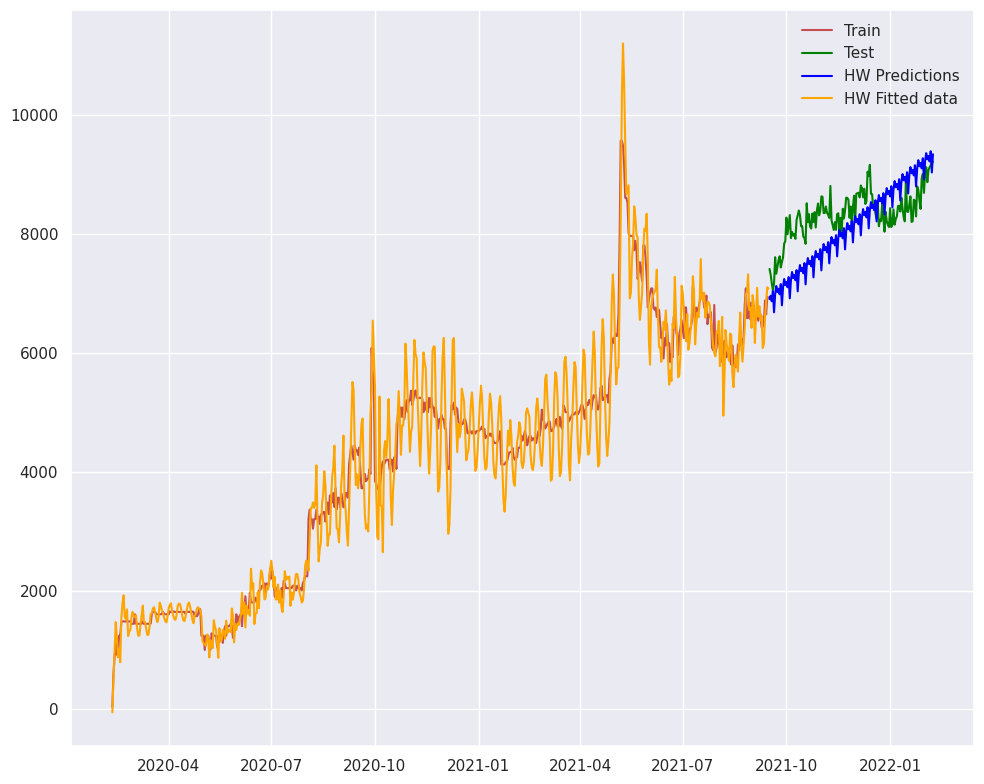

Delta-b
n= 200
RMSE: 858.1892739977159, MSE:736488.8300047267, MAPE:0.06571157704088576
Alpha: 0.5000000000000001, Beta:0.30000000000000004, Gamma:0.1


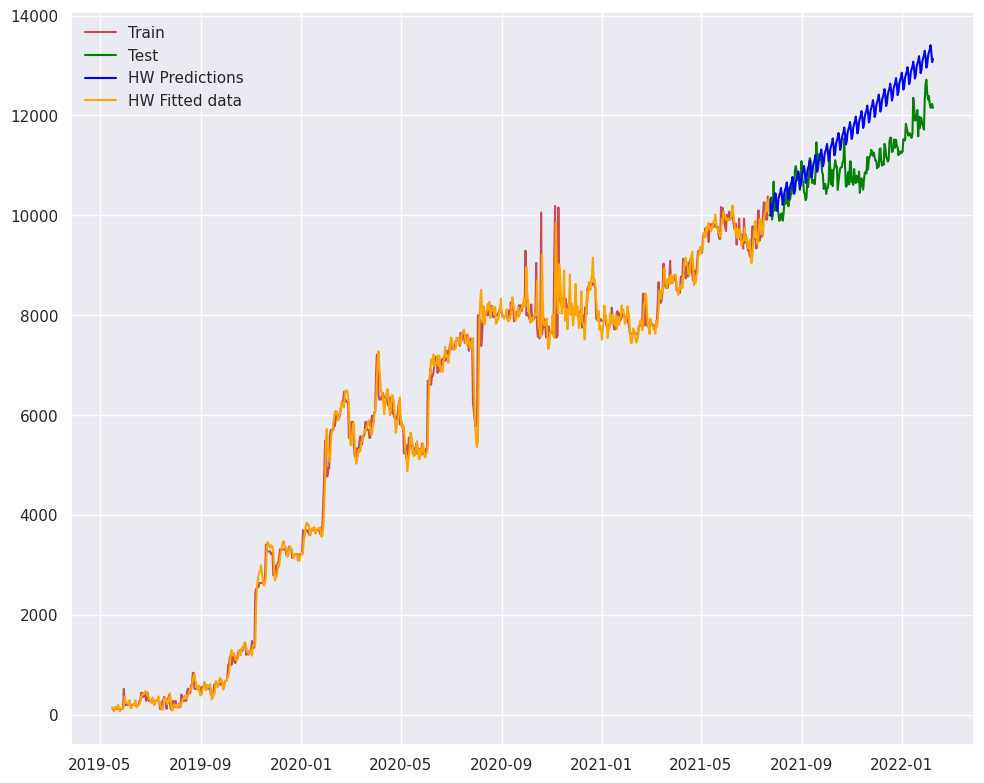

Delta-c
n= 200
RMSE: 519.0616030612276, MSE:269424.9477724914, MAPE:0.08054731625798162
Alpha: 0.5000000000000001, Beta:0.1, Gamma:0.30000000000000004


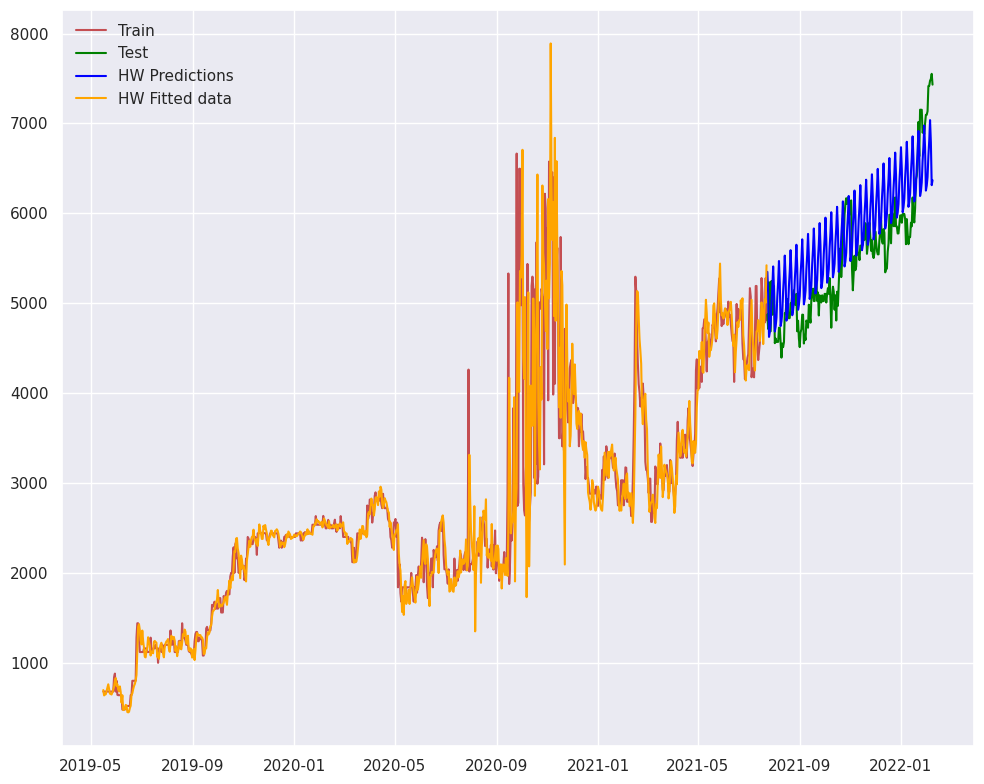

Epsilon-b
n= 200
RMSE: 345.9216076405228, MSE:119661.75863260377, MAPE:0.02983582164947152
Alpha: 0.1, Beta:0.1, Gamma:0.1


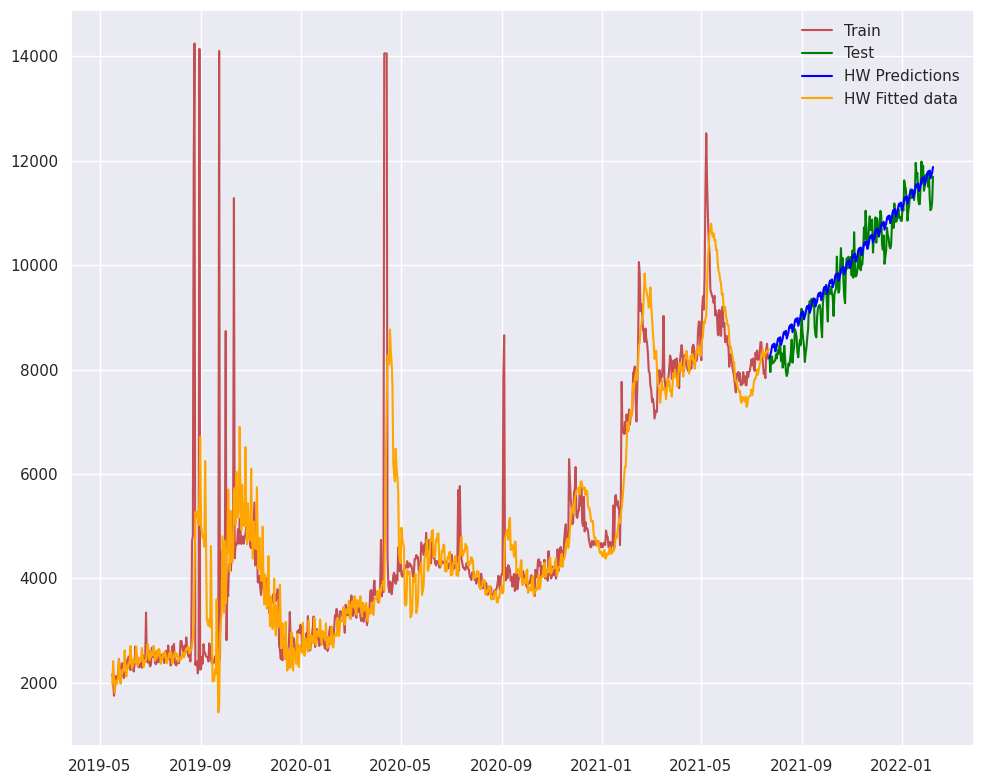

Epsilon-d
n= 200
RMSE: 384.31487237205266, MSE:147697.92112634712, MAPE:0.05025115852839732
Alpha: 0.7000000000000001, Beta:0.30000000000000004, Gamma:0.1


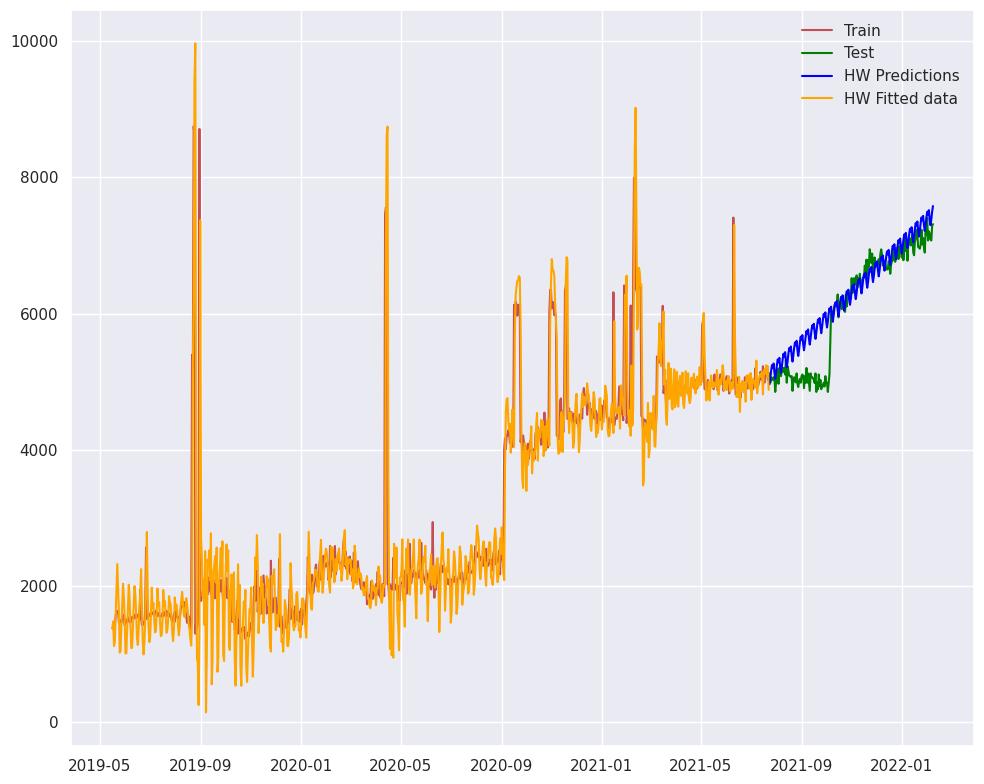

Gamma-a
n= 200
RMSE: 1828.8854455629505, MSE:3344821.9729919923, MAPE:0.01868527572940297
Alpha: 0.1, Beta:0.1, Gamma:0.30000000000000004


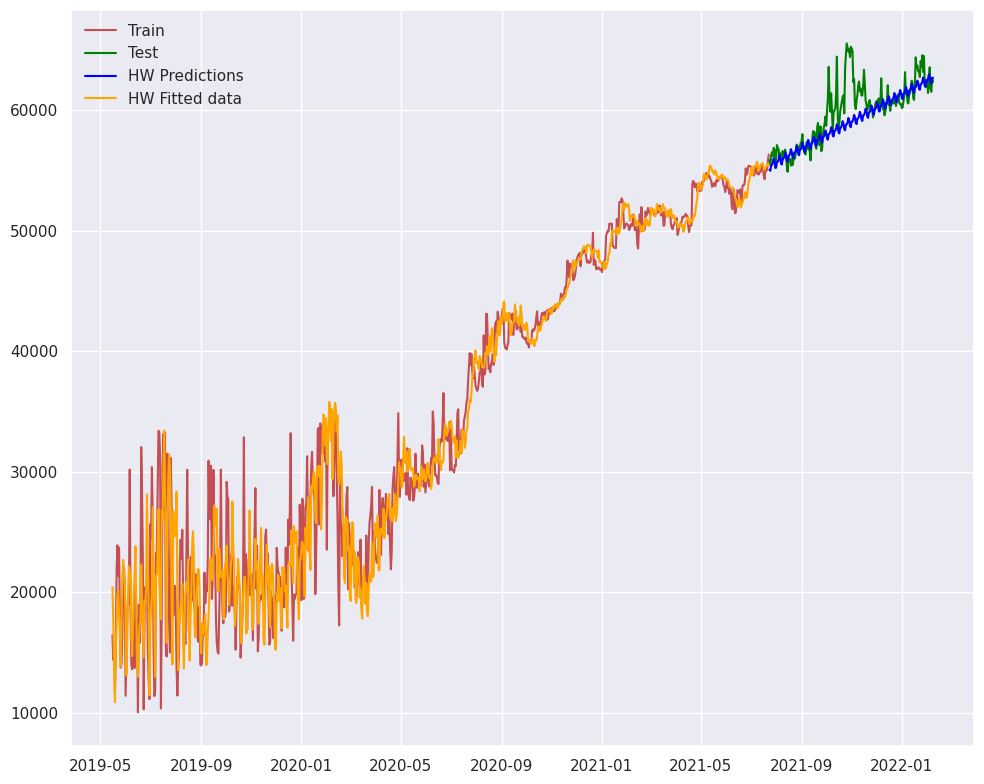

Gamma-b
n= 200
RMSE: 2424.908368168346, MSE:5880180.5940128695, MAPE:0.03147372492871692
Alpha: 0.1, Beta:0.1, Gamma:0.1


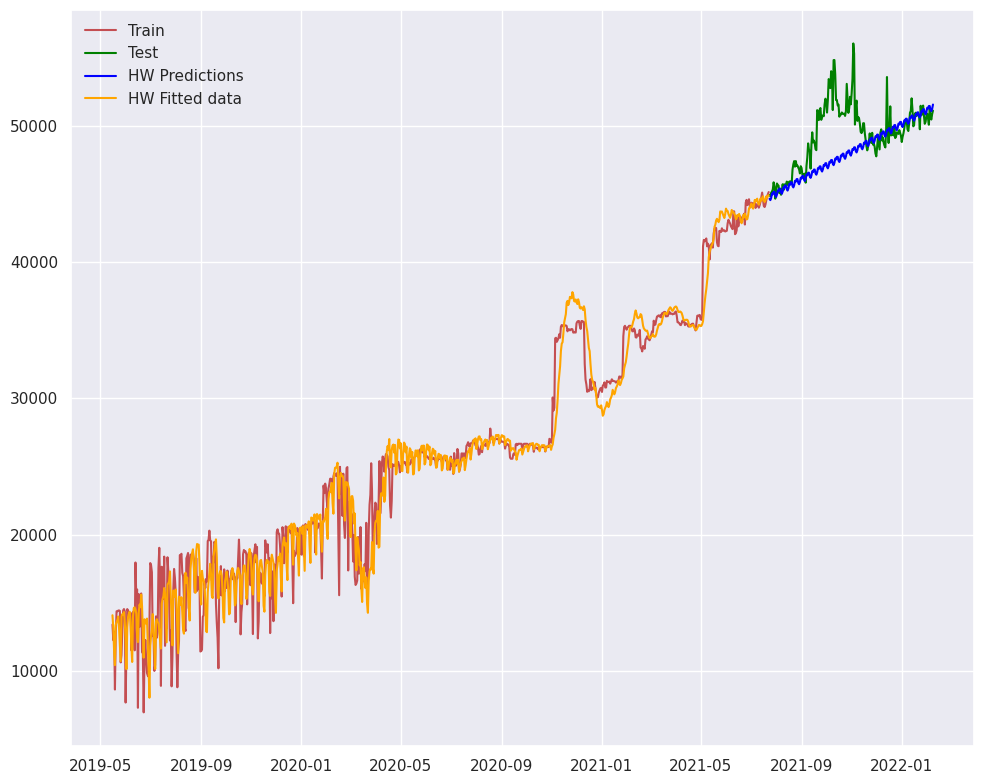

Gamma-c
n= 200
RMSE: 2076.200195997659, MSE:4310607.253860719, MAPE:0.09689036459596412
Alpha: 0.1, Beta:0.30000000000000004, Gamma:0.1


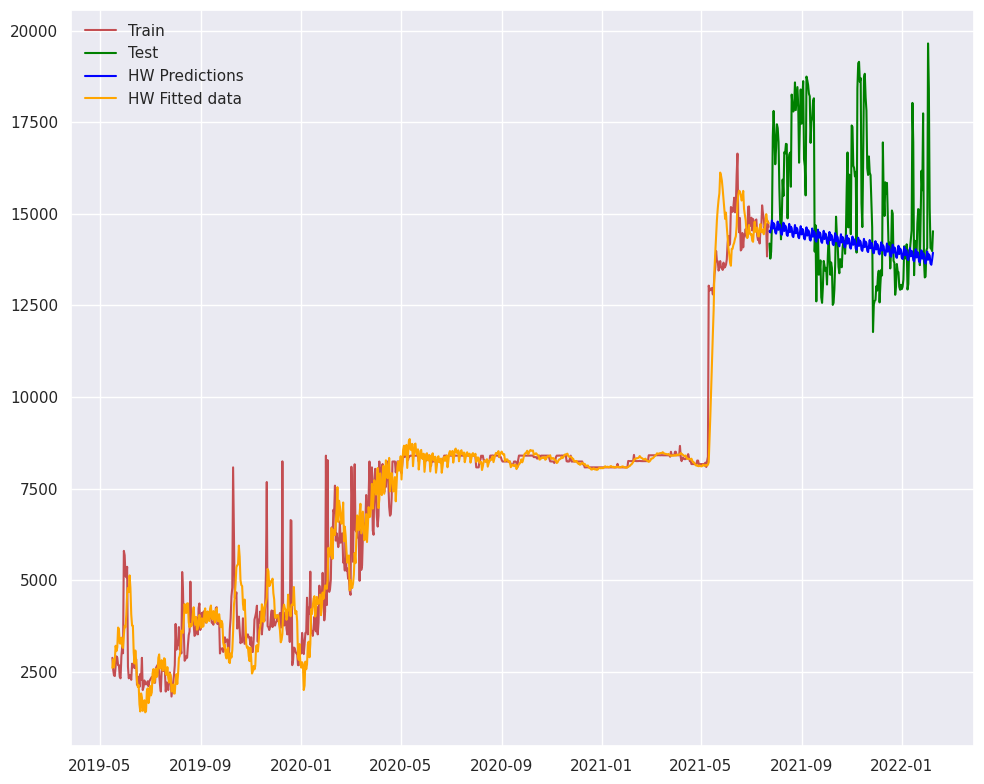

net
n= 200
RMSE: 7325.374096286173, MSE:53661105.65054046, MAPE:0.028303284130110285
Alpha: 0.5000000000000001, Beta:0.1, Gamma:0.7000000000000001


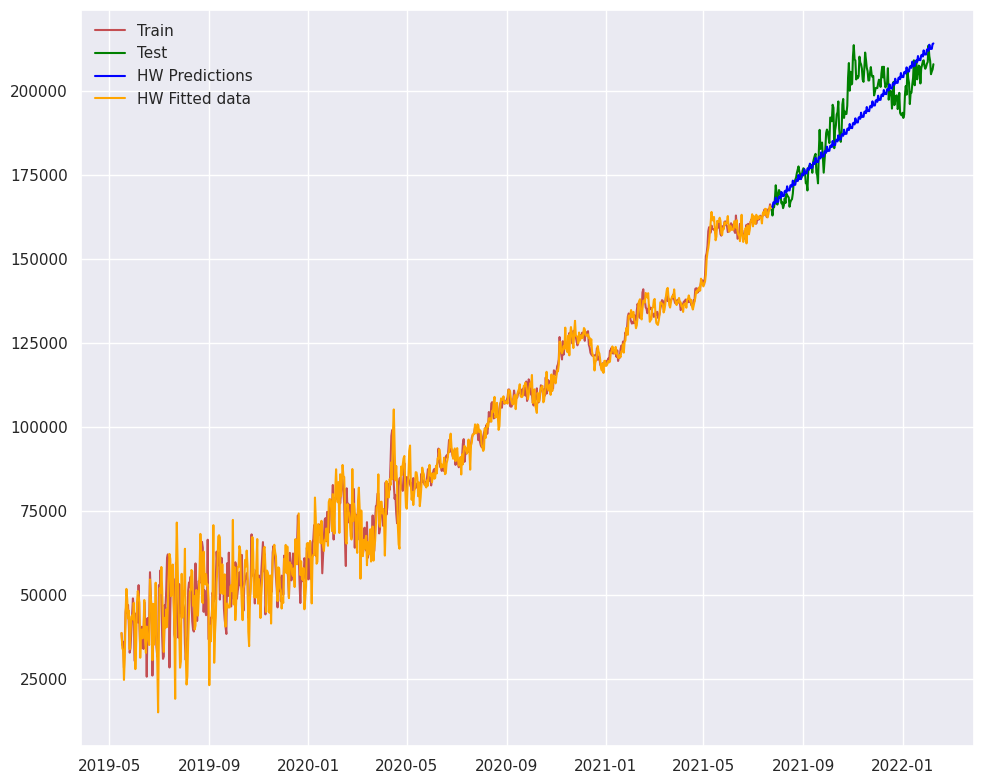

In [30]:
# Calculating for all product geographies

for i in range(1, len ( draft.columns )  ):  # Use 1 to len ( draft.columns ) to get all region zones data or use 11,12 (AS example) to get specifc region zones
    #print(i)

    sub_df = draft.loc[:, ['usage_date', draft.columns[i]]]
    holt_winters(sub_df, alpha[i-1],beta[i-1],gamma[i-1])

# 4.4 Prophet Model

The prophet model also includes the explaratory option and the forecasting model evaluation

In [31]:
# Install all prophet modules
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
# Loading all prophet modules

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings("ignore")

In [33]:
# function to forecast using prophet model

def prophet_forecasting(df):
  print(df.columns[1])
  df= df[df[df.columns[1]] != 0]
  df = df.rename(columns={'usage_date': 'ds', df.columns[1]: 'y'})

  train,test = train_test_split(df,train_size=0.8,shuffle=False)
  #print(train)
  #print(test)

  model=Prophet(weekly_seasonality=True)
  model.add_country_holidays(country_name='US')
  model.add_seasonality(name='weekly', period=7 ,fourier_order=7)
  model.fit(train)
  
  n=len(test)
  
  future = model.make_future_dataframe(periods=n)
  
  forecast=model.predict(future) # test data
  
  fig = model.plot(forecast)
  plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])
  plt.show()

  fig = model.plot_components(forecast)
  plt.show()

  # calculate MAE between observed and predicted values 
  y_true = test['y']
  y_pred = forecast.iloc[-len(test):]['yhat']
  mape = mean_absolute_percentage_error(y_true, y_pred)
  print("mape:",mape)

  start_index = test['ds'].min()
  end_index = test['ds'].max()

  #Plotting
 # visually compare actual and predictions
  fig, ax = plt.subplots(figsize=(10, 5))
  plt.plot(test['ds'], test['y'],  'k.', label='Actual')
  plt.plot(forecast['ds'], forecast['yhat'], label='Prediction')
  #ax.set_xlim(pd.Timestamp(start_index), pd.Timestamp('2020-09-01'))
  ax.set_xlim(start_index, end_index)
  ax.set_xlabel('ds')
  ax.set_ylabel('y')
  ax.legend()
  plt.grid(True, alpha=0.3)
  plt.show()



In [34]:
# Calculating for all product geographies

for i in range(1, len ( draft.columns )  ): # Use 1 to len ( draft.columns ) to get all region zones data or use 11,12 (AS example) to get specifc region zones
    #print(i)

    sub_df = draft.loc[:, ['usage_date', draft.columns[i]]]
    prophet_forecasting(sub_df)

Output hidden; open in https://colab.research.google.com to view.

# 4.5 Basic Linear Regression Model (BaSe Model )

This module has a base model using linear regression between sales data and the time index ( t=0,1,2.... ) for each region zone option

In [35]:
from operator import le

def linear_reg_simple(df):

  df=df.drop(['usage_date'],axis=1)
  df= df[df[df.columns[0]] != 0]
  
  df['time'] = np.arange(1,len(df)+1)
  print(df.columns[0])

  y=np.array(df[df.columns[0]]) # Y values
  X=np.array(df[df.columns[1]]) # X Values. It is time in days since launch
  
  # Train Test Split
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

  # Model Fitting
  model = LinearRegression(fit_intercept=False)
  model.fit(X_train.reshape(-1,1), y_train)

  # Model Prediction and evaluation
  y_pred = model.predict(X_valid.reshape(-1,1)) # Prediction 
  mape = mean_absolute_percentage_error(y_valid, y_pred) # Calculating the MAPE values

  print("mape:",mape)
  
  original=np.concatenate((y_train,y_valid))
  predicted=np.concatenate((y_train,y_pred))

  #Plotting
  plt.plot(predicted , label='Predictions',color='blue')
  plt.plot(original , label='Original',color='green')
  
  plt.legend();
  fig = plt.gcf()
  fig.set_size_inches(10, 8)#
  plt.show()


Alpha-a
mape: 0.4648167407234032


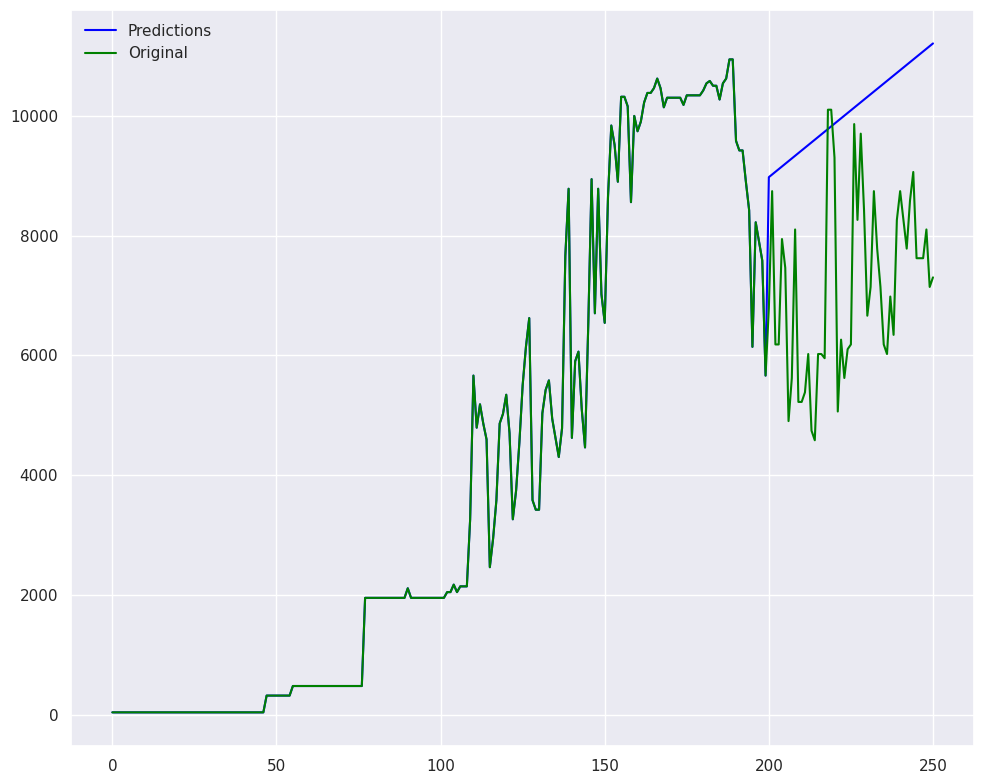

Alpha-b
mape: 0.7888236206032626


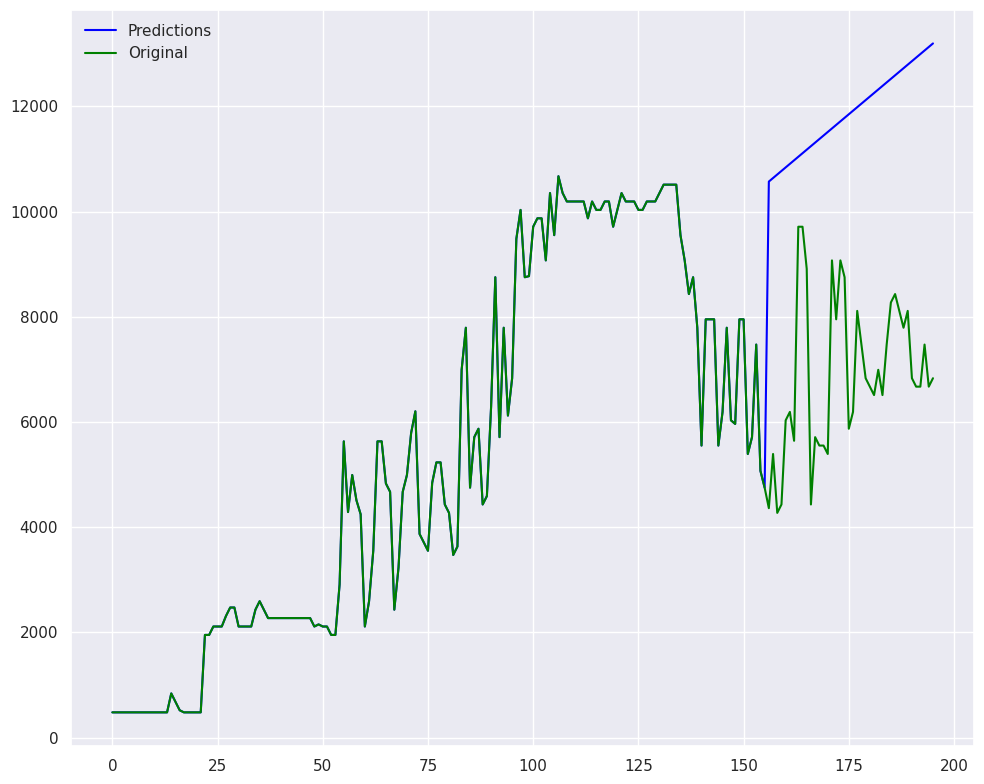

Beta-a
mape: 0.3056835273606414


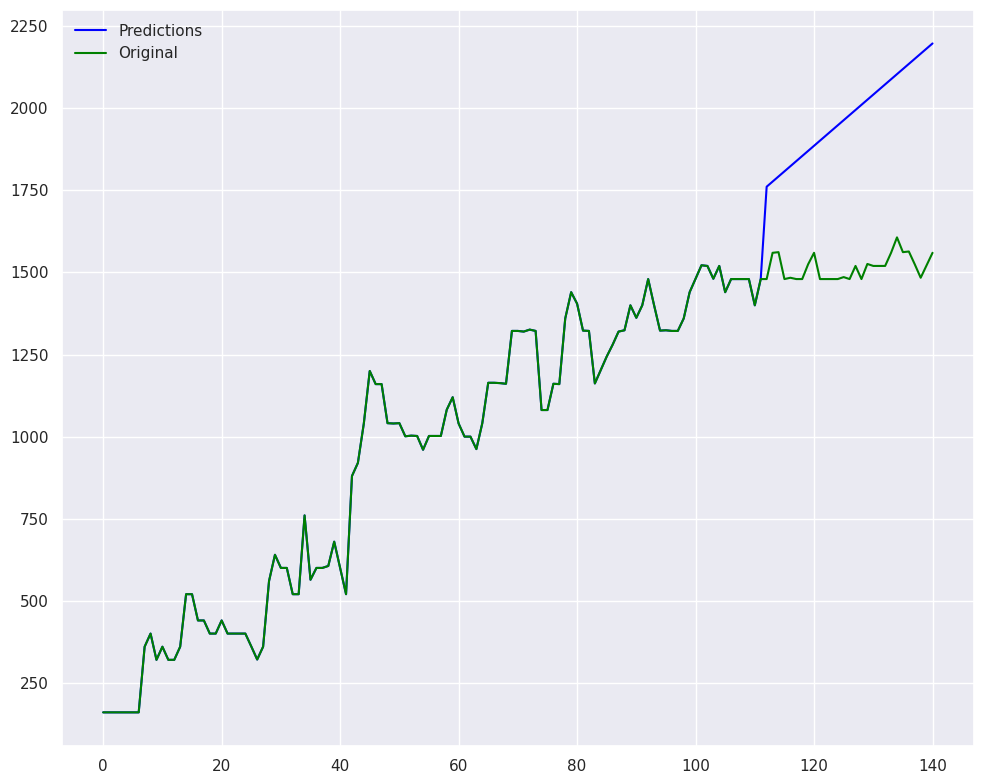

Beta-b
mape: 0.08955422451615667


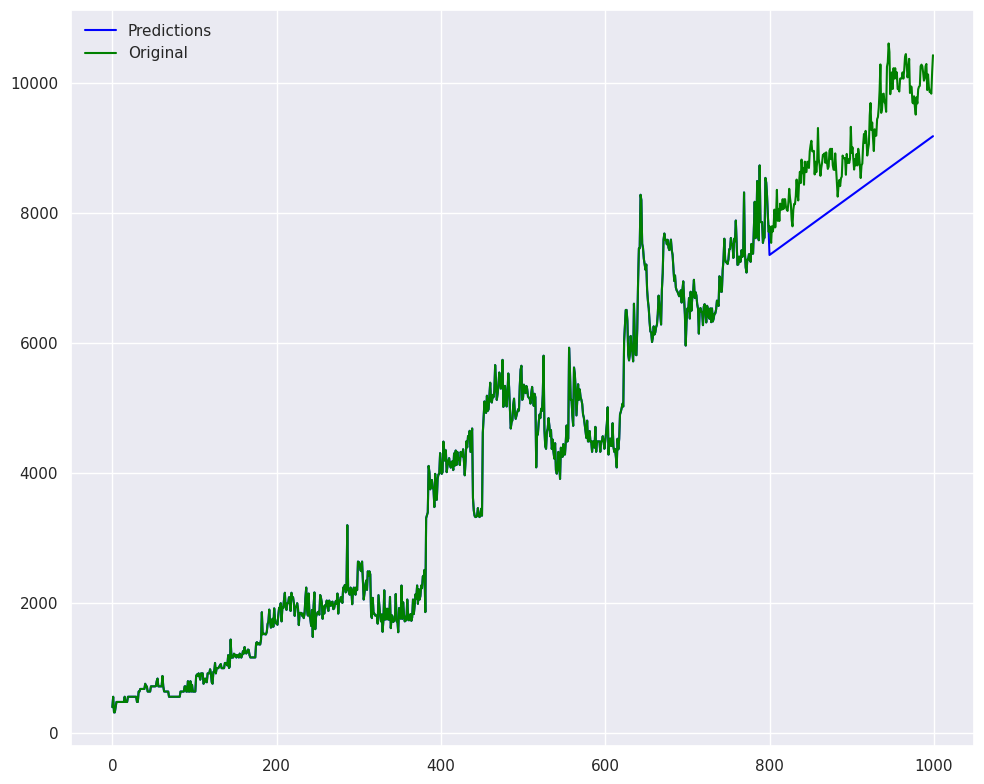

Beta-c
mape: 0.24451217267248612


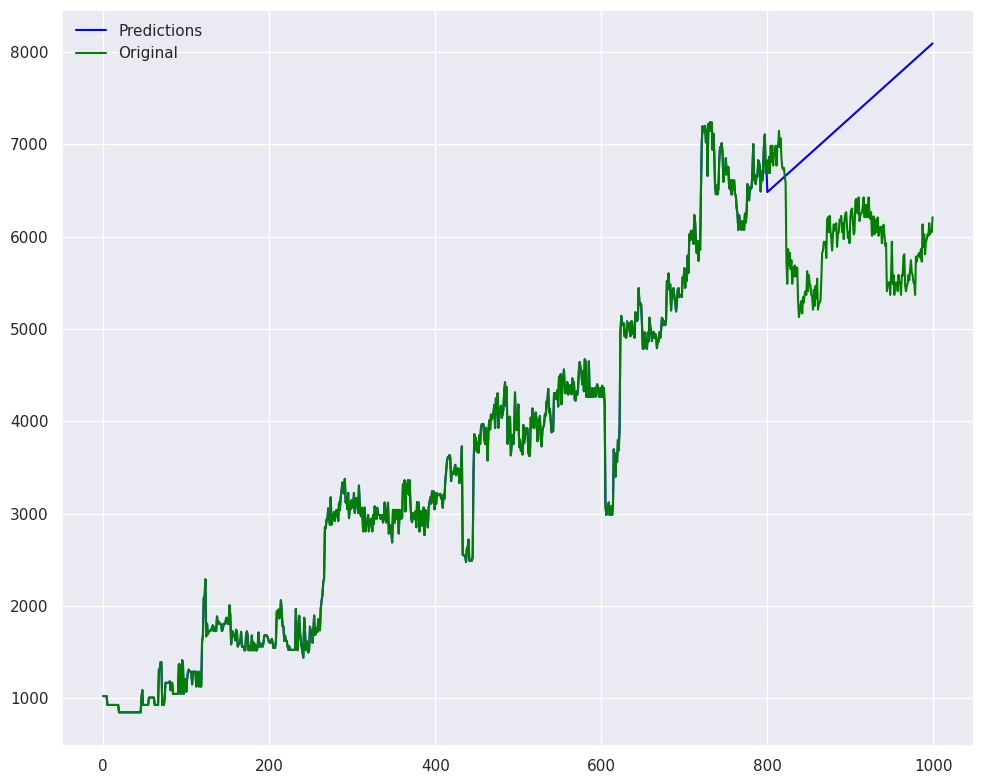

Delta-a
mape: 0.06726996210844577


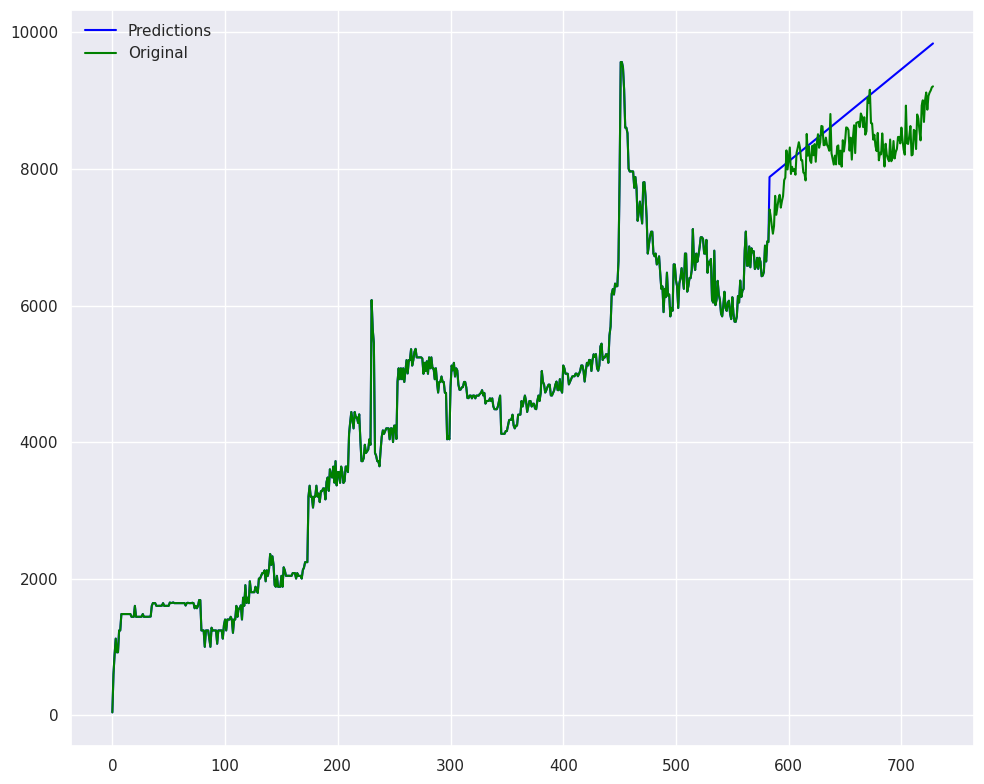

Delta-b
mape: 0.14238069616893298


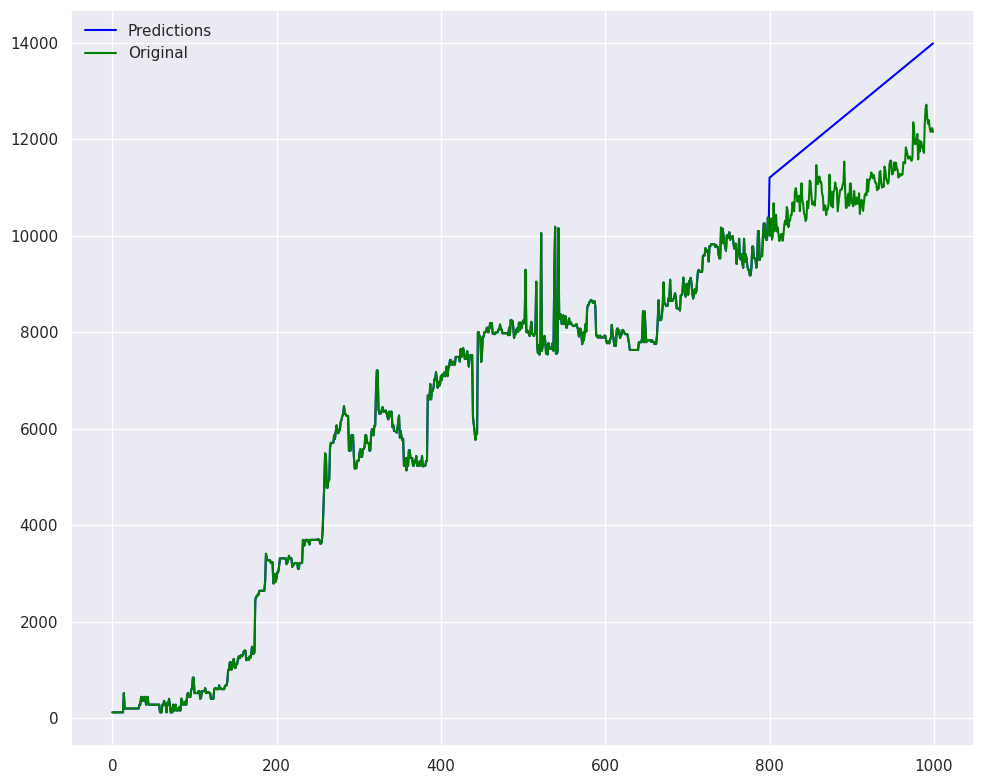

Delta-c
mape: 0.05567356086606155


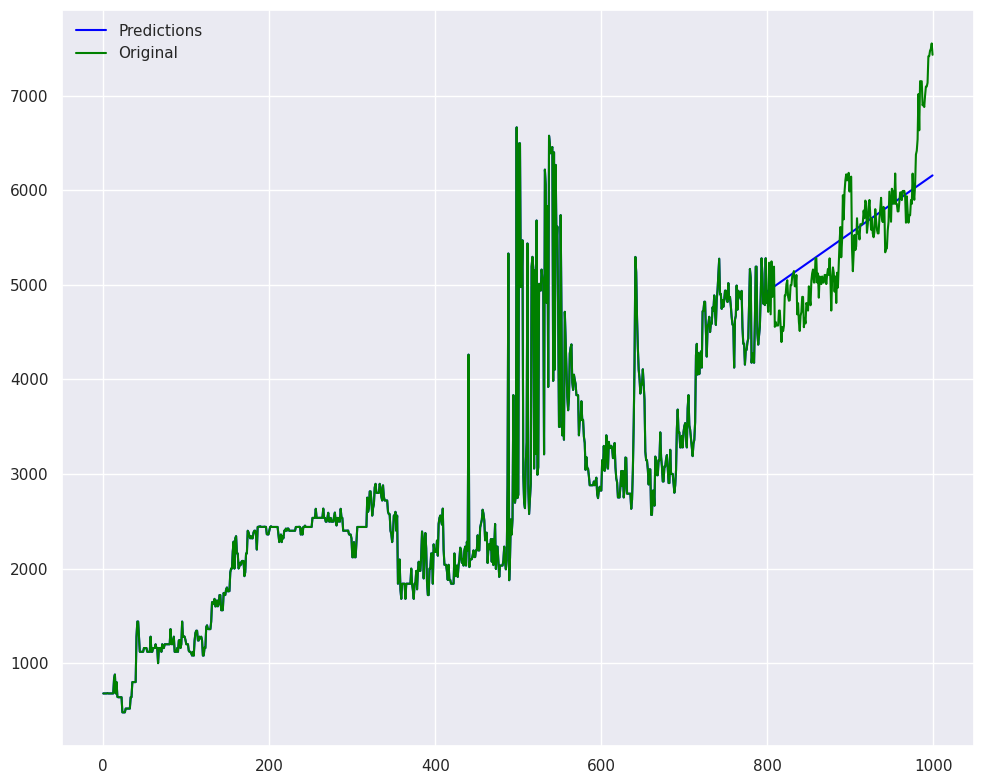

Epsilon-b
mape: 0.04891092980960643


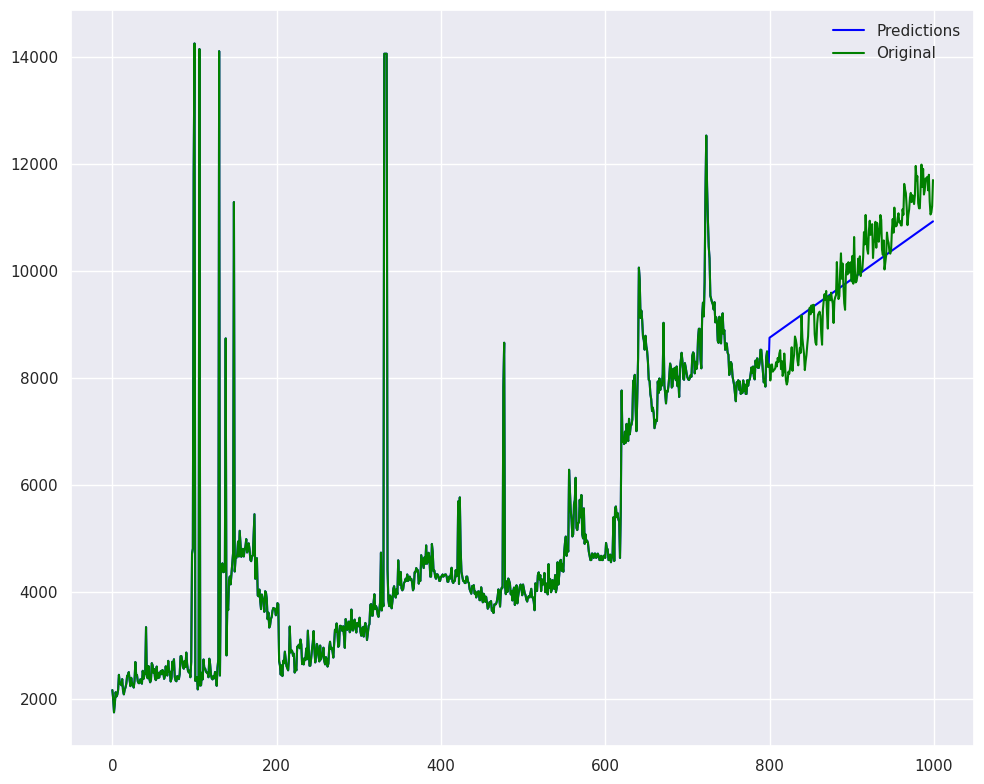

Epsilon-d
mape: 0.0972525951132683


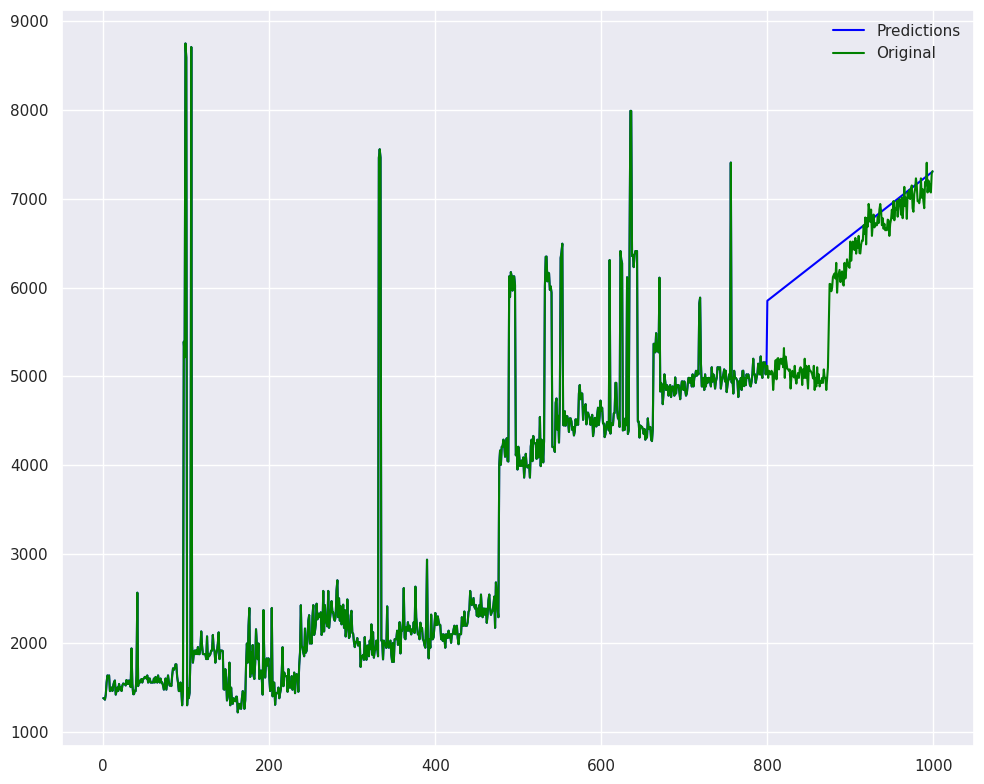

Gamma-a
mape: 0.19404051949173678


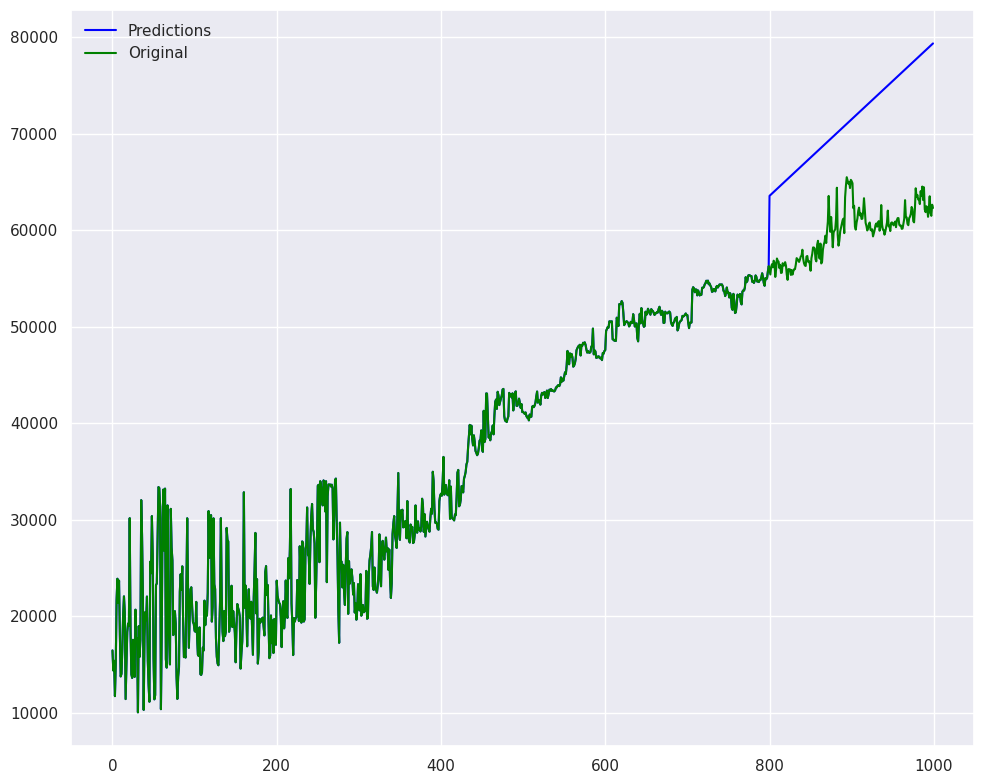

Gamma-b
mape: 0.06930779400172177


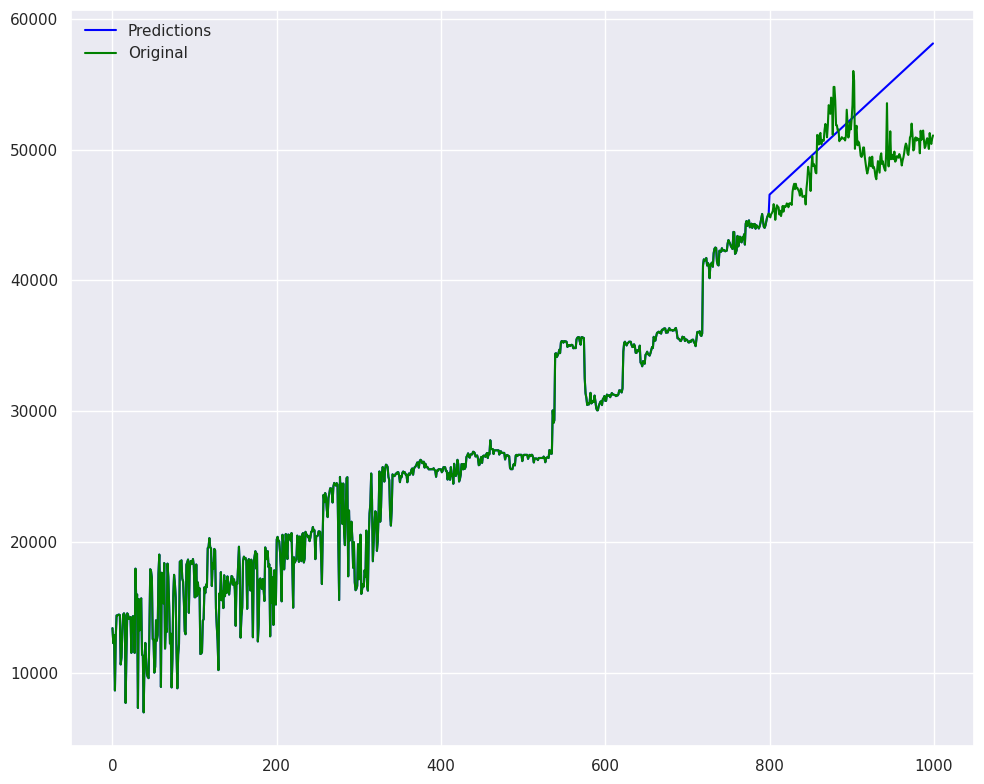

Gamma-c
mape: 0.13200686604613499


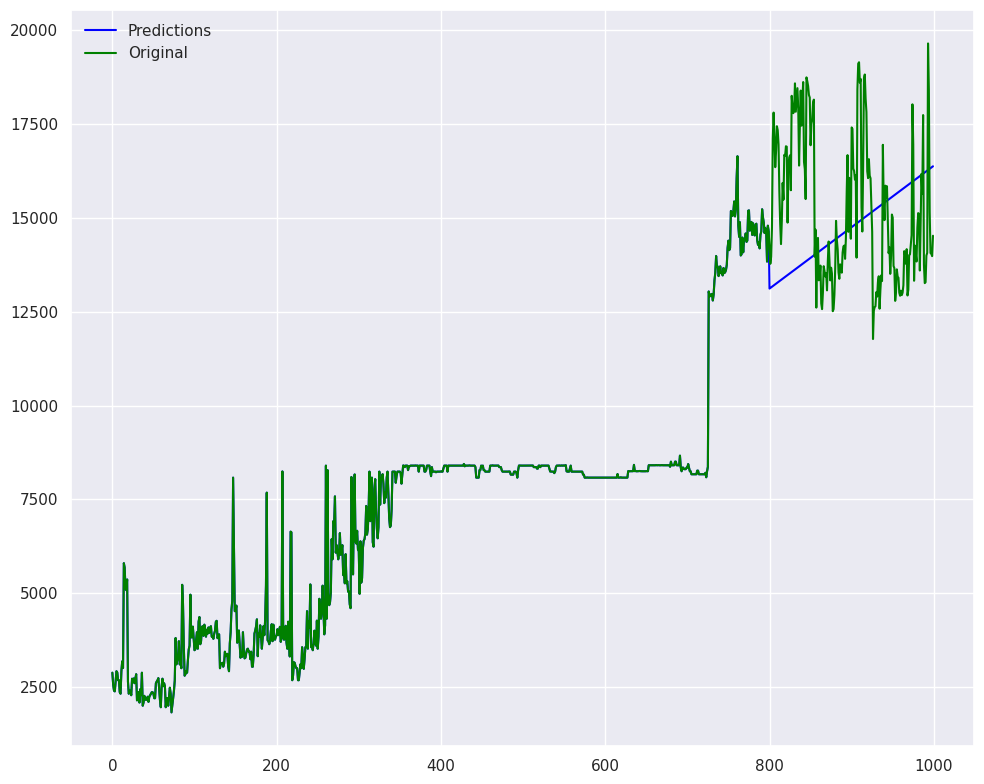

net
mape: 0.036484578520335965


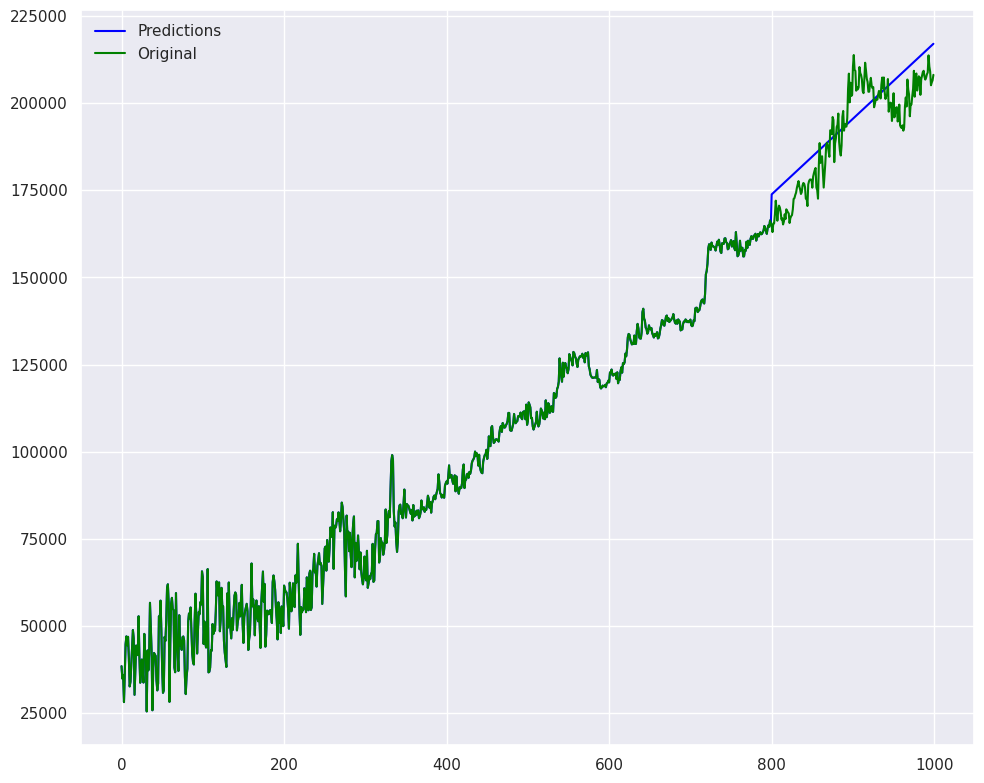

In [36]:
# Calculating for all product geographies

for i in range(1, len ( draft.columns )  ): # Use 1 to len ( draft.columns ) to get all region zones data or use 11,12 (AS example) to get specifc region zones
    #print(i)

    sub_df = draft.loc[:, ['usage_date', draft.columns[i]]]
    linear_reg_simple(sub_df)

# 4.6 Naive Model

In [37]:
# Naive Model forecasting and MAPE calculation

In [38]:
def naive_forecasting(df):

  #print(df)
  s = df.columns[1]
  print(s) 
  
  df= df.set_index('usage_date')
  df= df[df[df.columns[0]] != 0]
  
  y =  pd.DataFrame(df[df.columns[0]])
  #print(y)
  #print(y.columns)
  
  # Train and Test data for modelling
  train,test = train_test_split(y,train_size=0.8,shuffle=False)
  train_len = len(train)

  #print(train)

  y_naive = test.copy()
  y_naive['naive_fc'] = train[df.columns[0]][train_len-1]
  #print(y_naive)

  mape = mean_absolute_percentage_error( y_naive['naive_fc'], test[df.columns[0]]) # Calculating the MAPE values
  print("MAPE is ", mape)

  plt.figure(figsize=(10,5))
  plt.grid()
  plt.plot(train[df.columns[0]], label='Train')
  plt.plot(test[df.columns[0]], label='Test')
  plt.plot(y_naive['naive_fc'], label='Naive forecast')
  plt.legend(loc='best')  
  plt.title('Naive Method')
  plt.show()

Alpha-a
MAPE is  0.29636784092167945


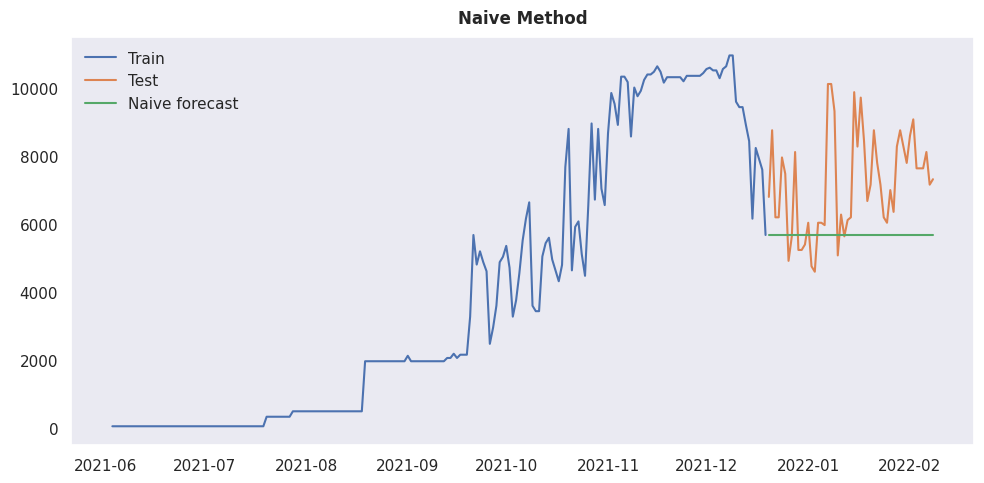

Alpha-b
MAPE is  0.47138573232323233


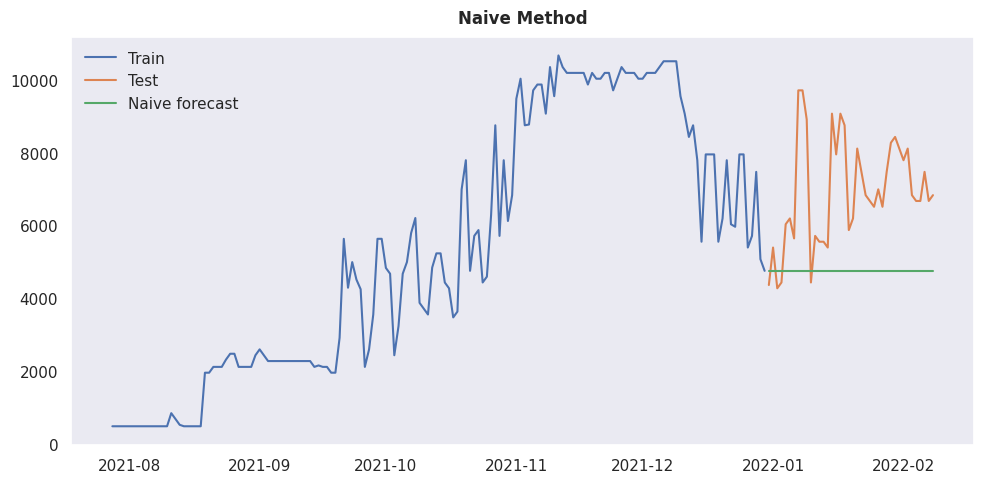

Beta-a
MAPE is  0.024394221808014913


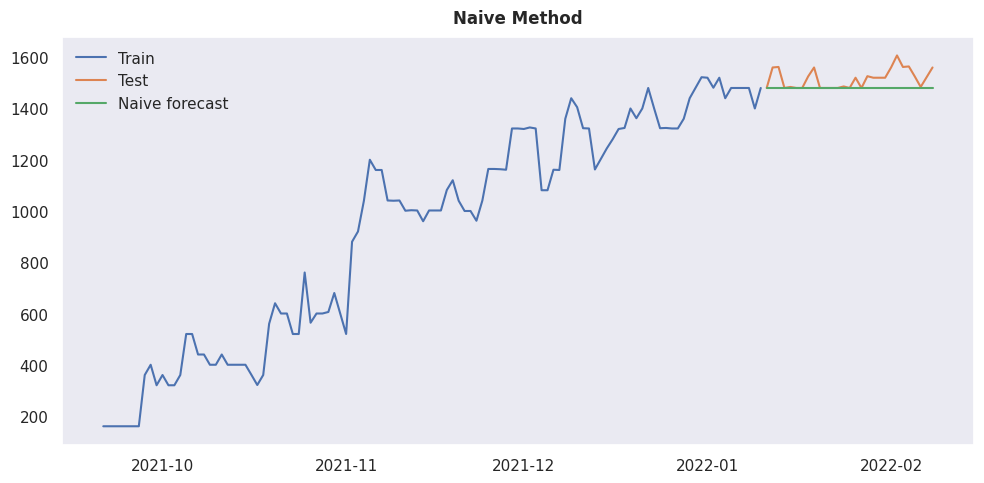

Beta-b
MAPE is  0.18053545961363932


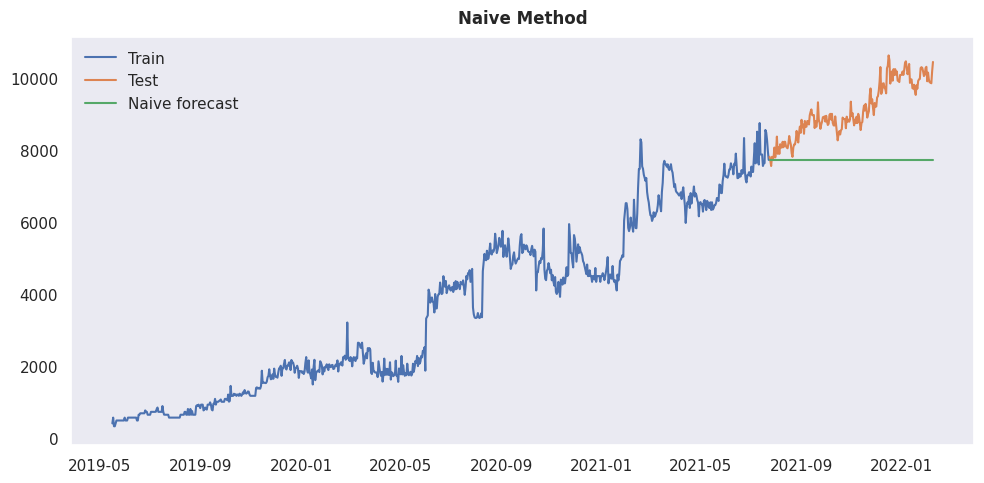

Beta-c
MAPE is  0.12185242978154256


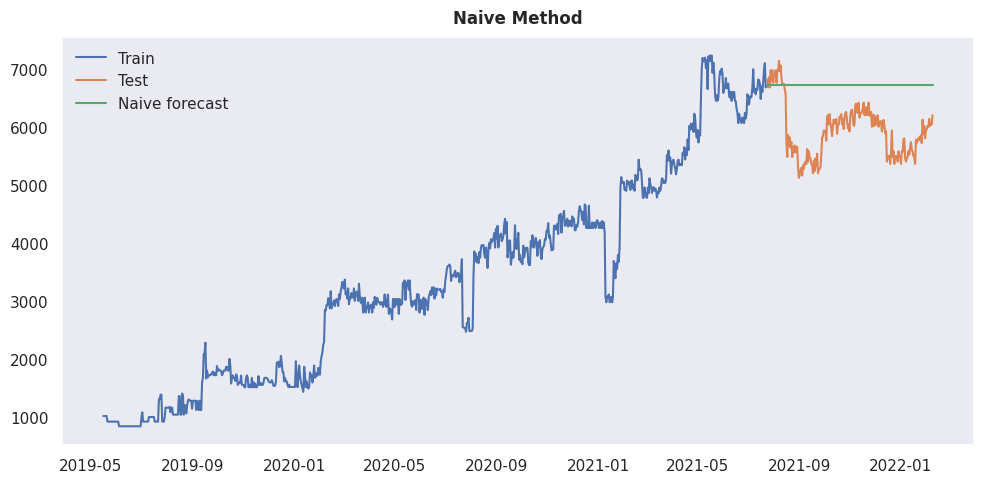

Delta-a
MAPE is  0.2010209729387812


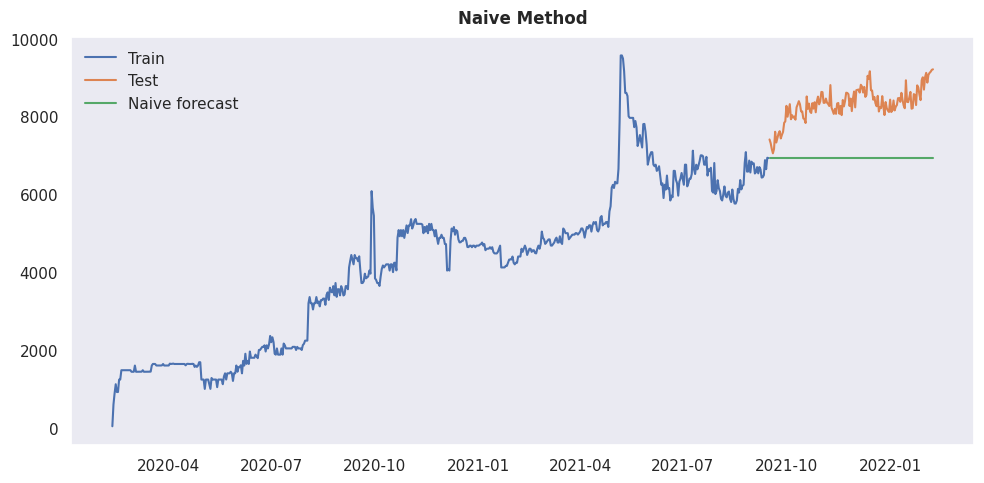

Delta-b
MAPE is  0.09064512942106302


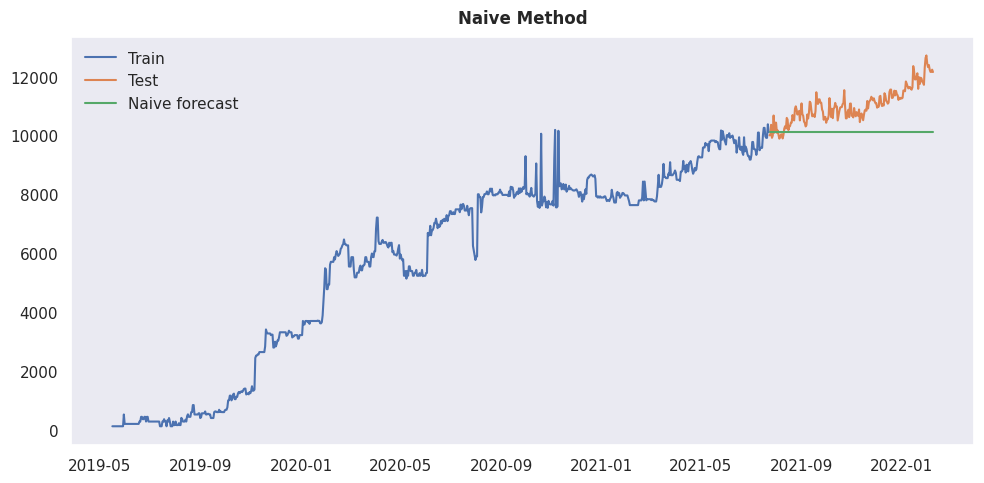

Delta-c
MAPE is  0.1588856548856549


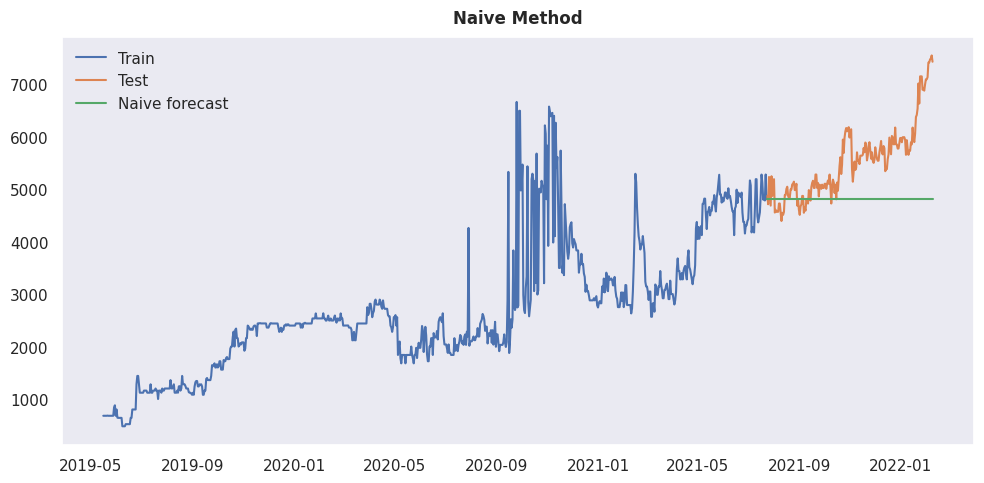

Epsilon-b
MAPE is  0.20714694424153884


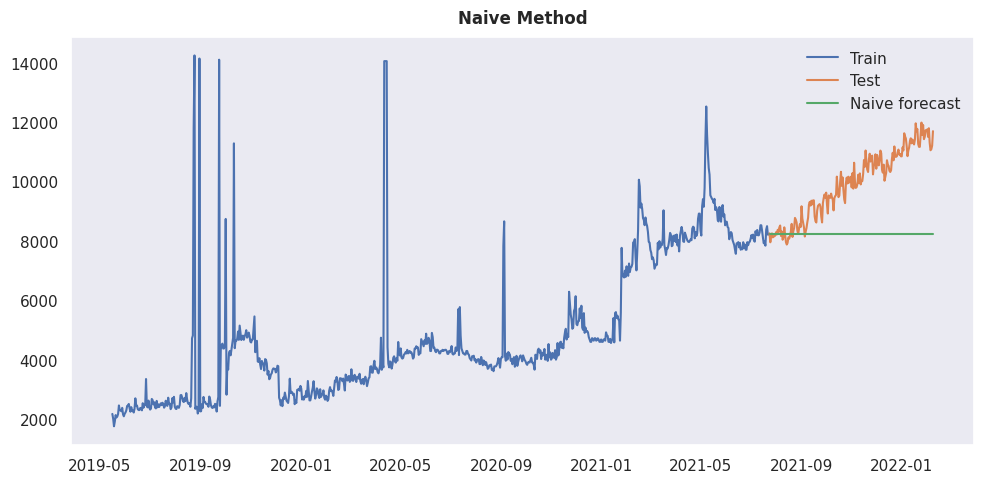

Epsilon-d
MAPE is  0.200466796875


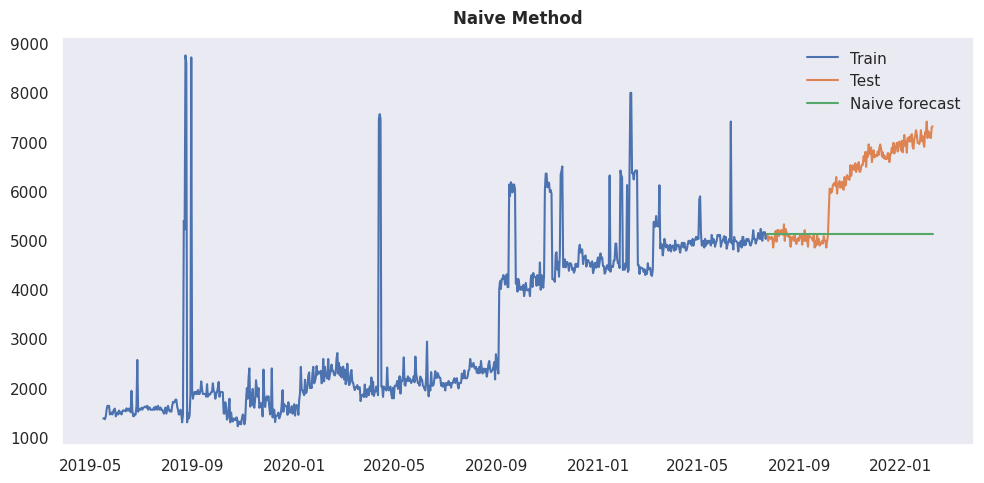

Gamma-a
MAPE is  0.06495657964837508


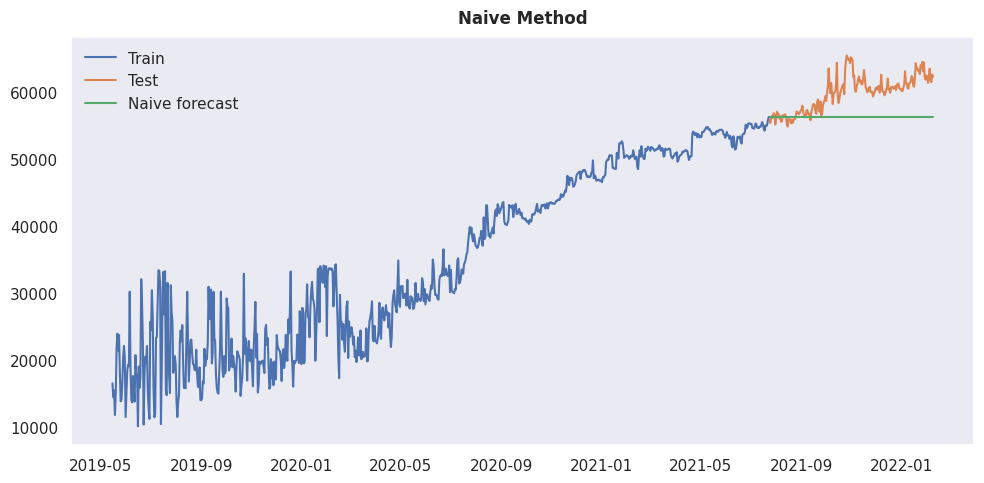

Gamma-b
MAPE is  0.0941354741484387


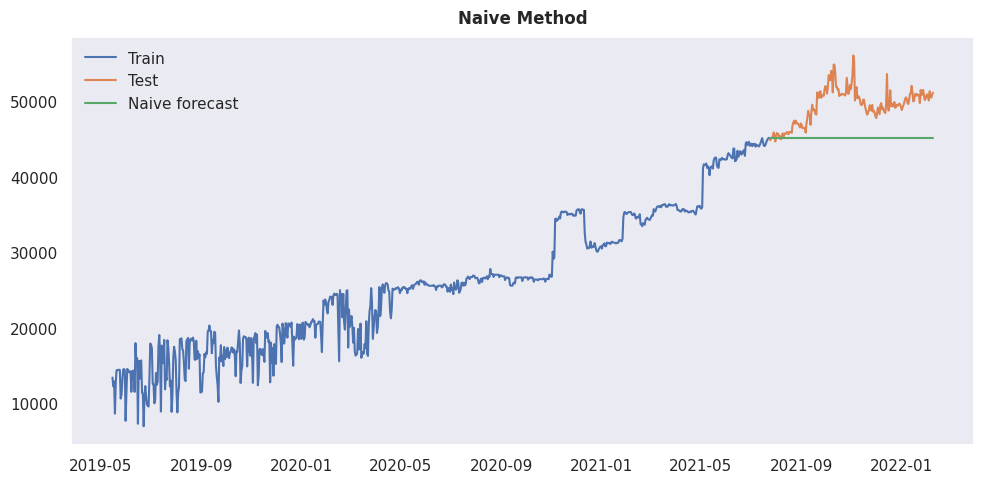

Gamma-c
MAPE is  0.11053066520967082


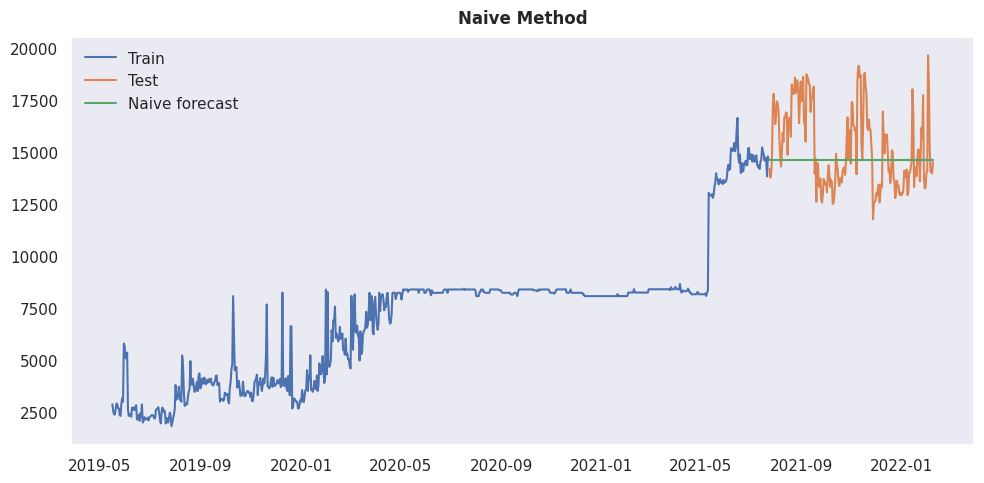

net
MAPE is  0.15837818495860084


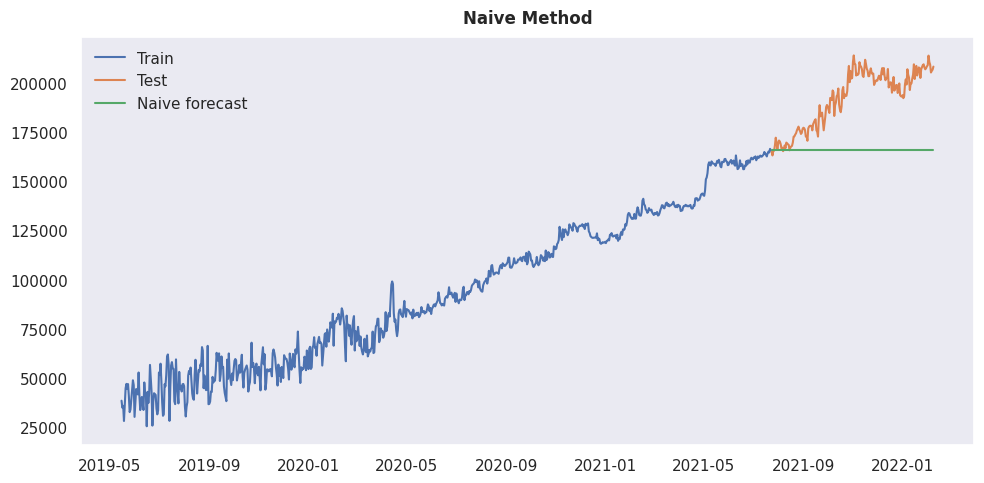

In [39]:
# Calculating for all product geographies

for i in range(1, len ( draft.columns )  ): # Use 1 to len ( draft.columns ) to get all region zones data or use 11,12 (AS example) to get specifc region zones
    #print(i)

    sub_df = draft.loc[:, ['usage_date', draft.columns[i]]]
    naive_forecasting(sub_df)

# 4.7 Moving Average Method

In [40]:
# Moving Average forecast

In [41]:
def ma_forecasting(df):

  #print(df)
  s = df.columns[1]
  print(s) 
  
  df= df.set_index('usage_date')
  df= df[df[df.columns[0]] != 0]
  
  y =  pd.DataFrame(df[df.columns[0]])
  #print(y)
  y_ma = y.copy()
  ma_window = 7
  y_ma['ma_7'] = y[df.columns[0]].rolling(ma_window).mean()
  #print(y_ma)

  #print(y.columns)
  
  # Train and Test data for modelling
  train,test = train_test_split(y_ma,train_size=0.8,shuffle=False)
  #train_len = len(train)

  #print(test)

  mape = mean_absolute_percentage_error( test['ma_7'], test[df.columns[0]]) # Calculating the MAPE values
  print("MAPE is ", mape)

  plt.figure(figsize=(10,5))
  plt.grid()
  plt.plot(train[df.columns[0]], label='Train')
  plt.plot(test[df.columns[0]], label='Test')
  plt.plot(test['ma_7'], label='MA forecast')
  plt.legend(loc='best')  
  plt.title('Moving Average (7 Days) Method')
  plt.show()

Alpha-a
MAPE is  0.1593626698274563


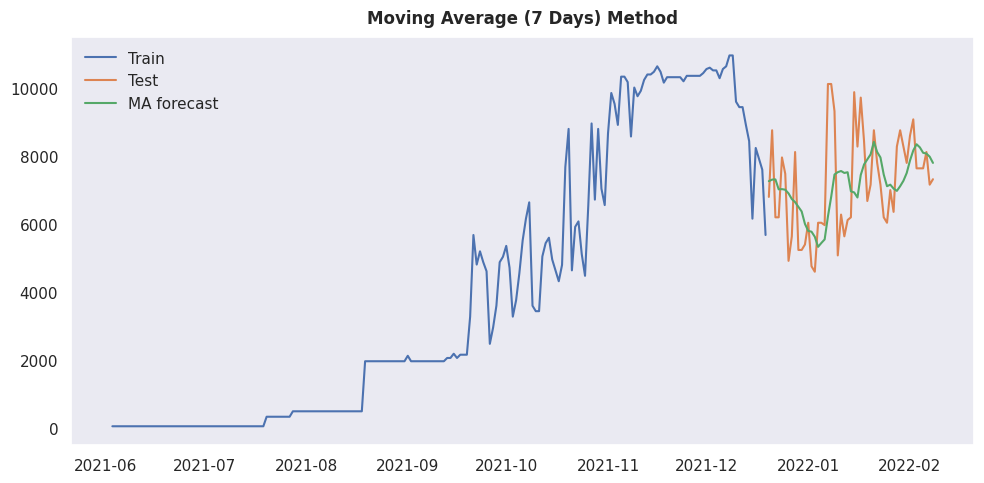

Alpha-b
MAPE is  0.16534951597301234


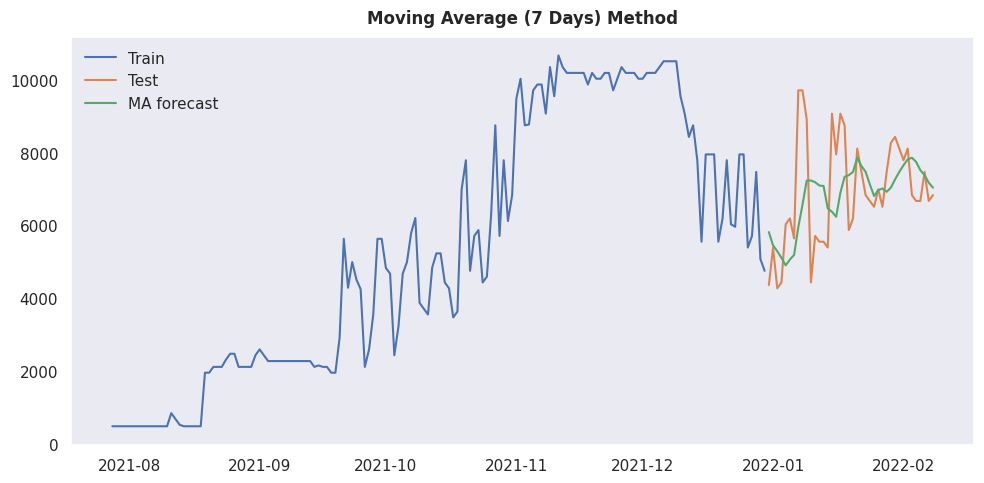

Beta-a
MAPE is  0.017837561990156302


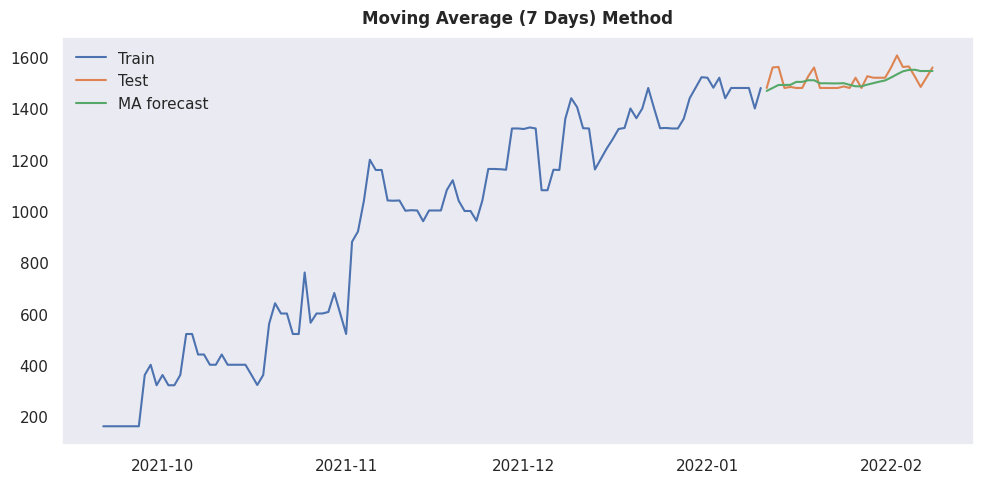

Beta-b
MAPE is  0.017110962577917162


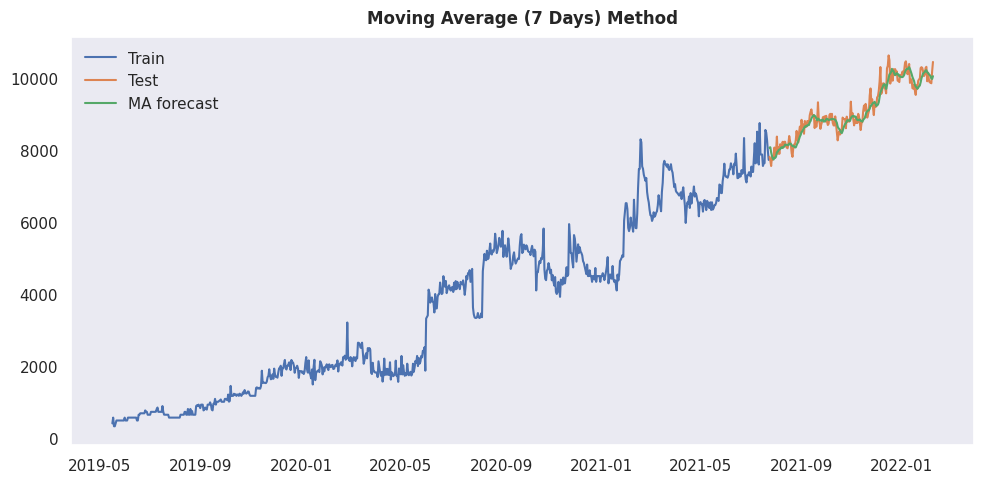

Beta-c
MAPE is  0.02020211291158245


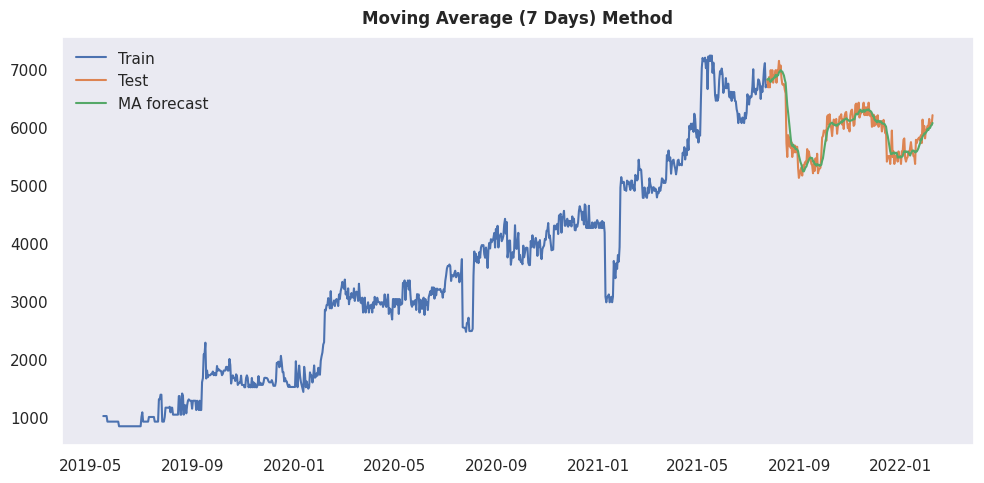

Delta-a
MAPE is  0.020034157539074223


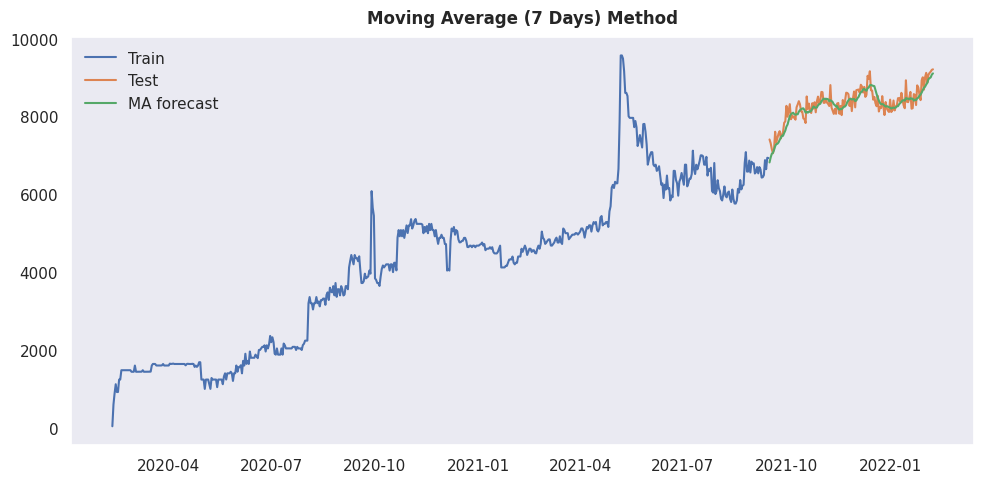

Delta-b
MAPE is  0.014725841631944276


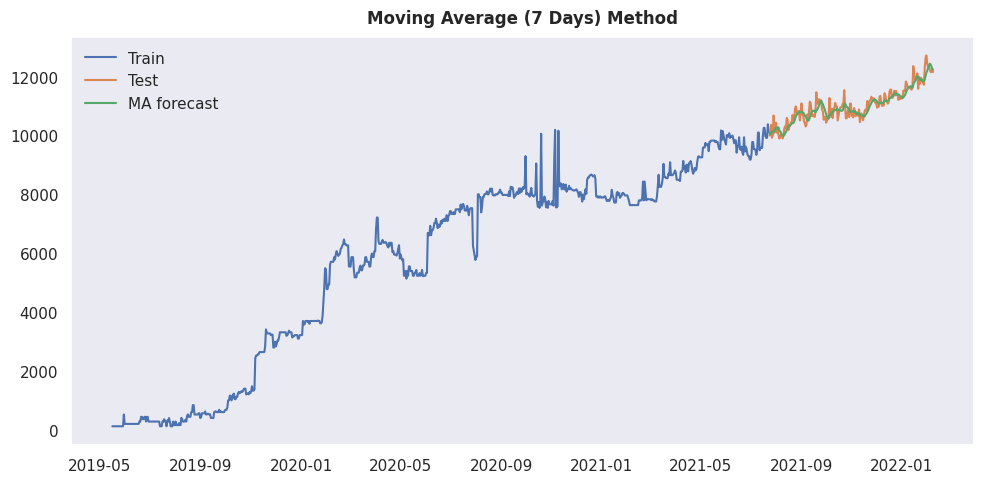

Delta-c
MAPE is  0.026679144512961928


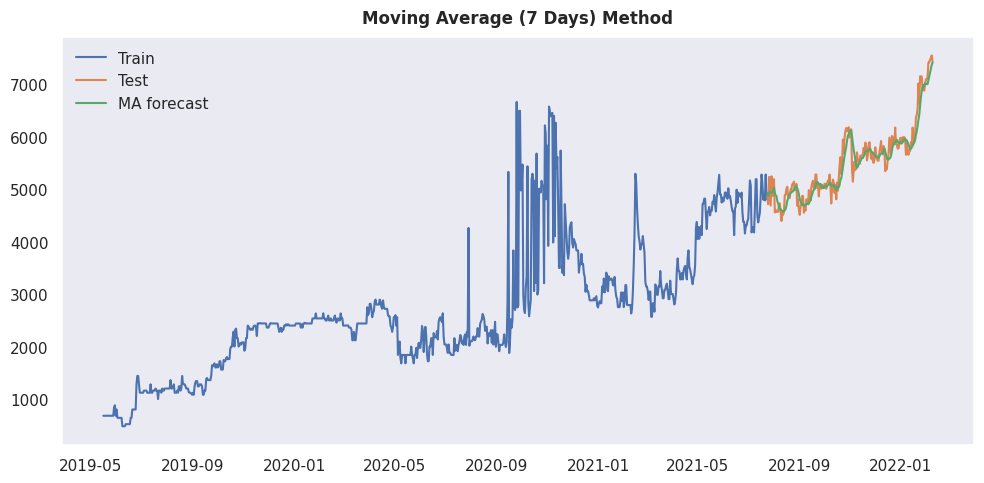

Epsilon-b
MAPE is  0.02095109558812103


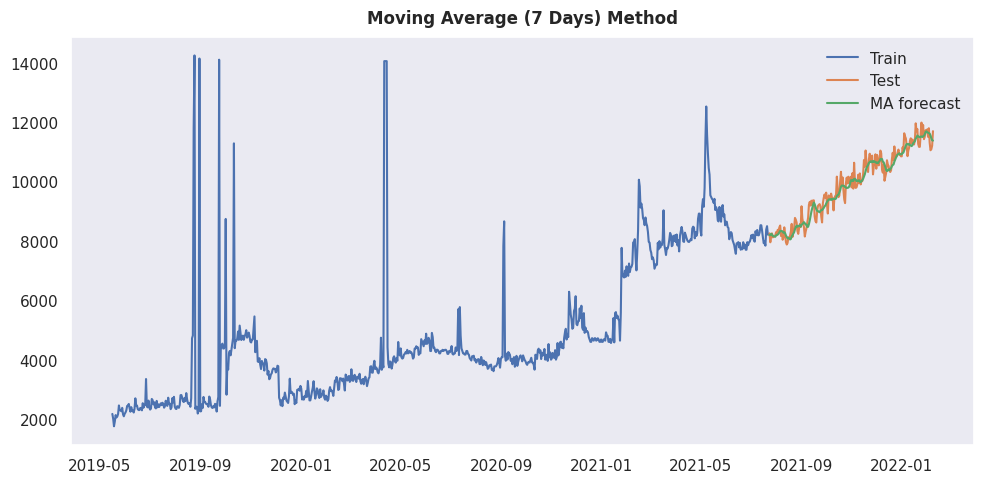

Epsilon-d
MAPE is  0.015104614928515354


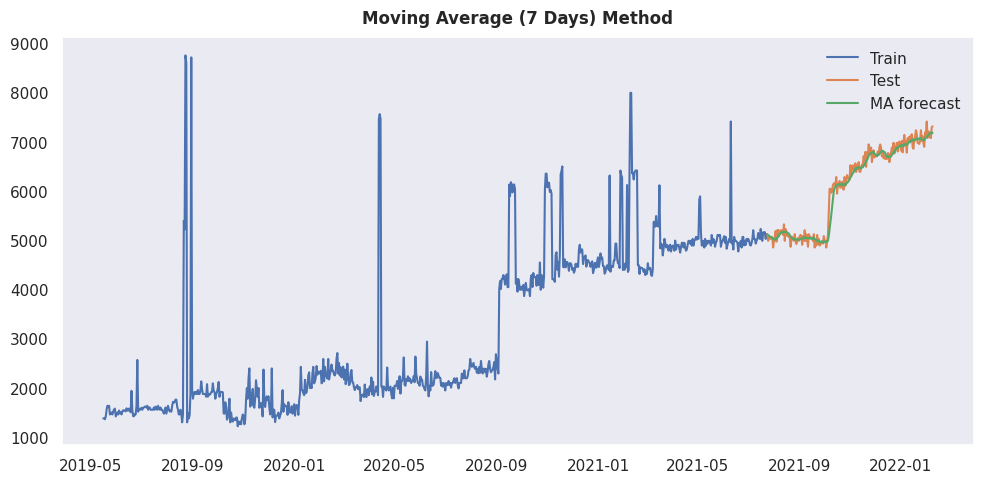

Gamma-a
MAPE is  0.011809096235623566


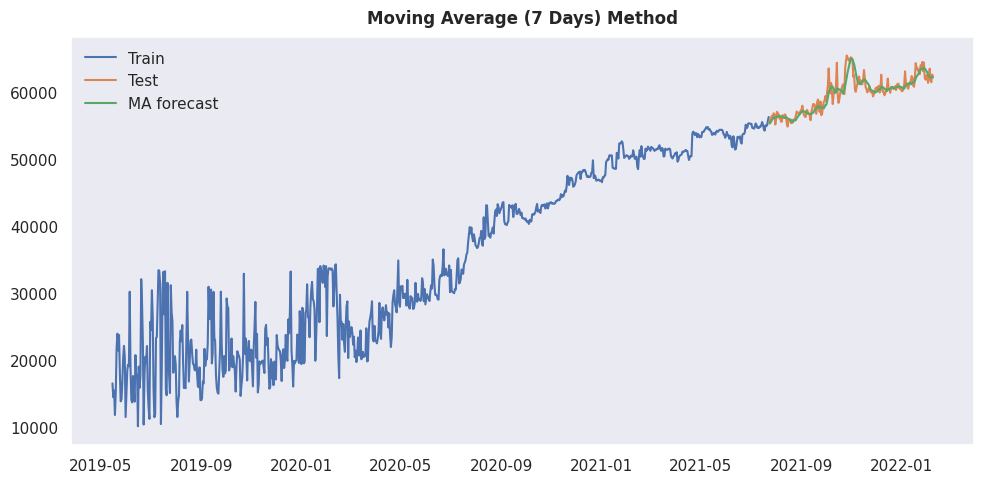

Gamma-b
MAPE is  0.011614615934276066


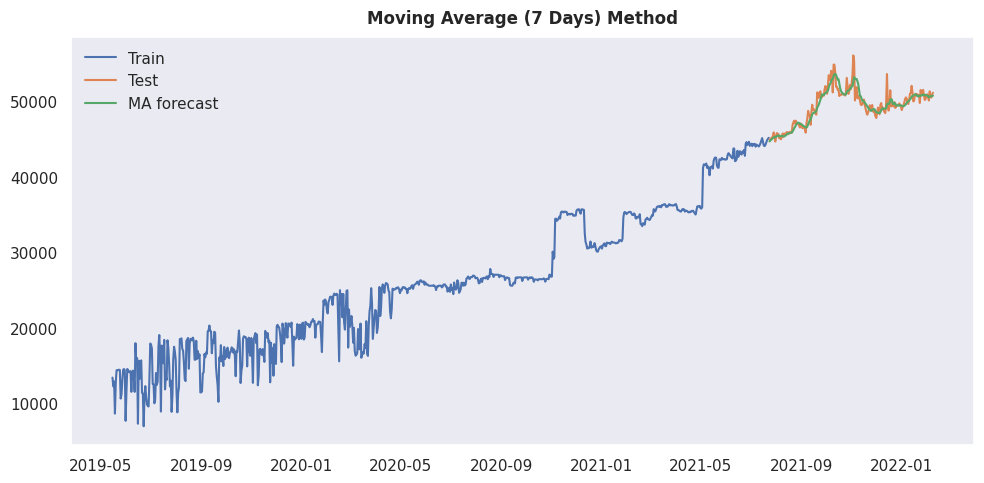

Gamma-c
MAPE is  0.058582290736592706


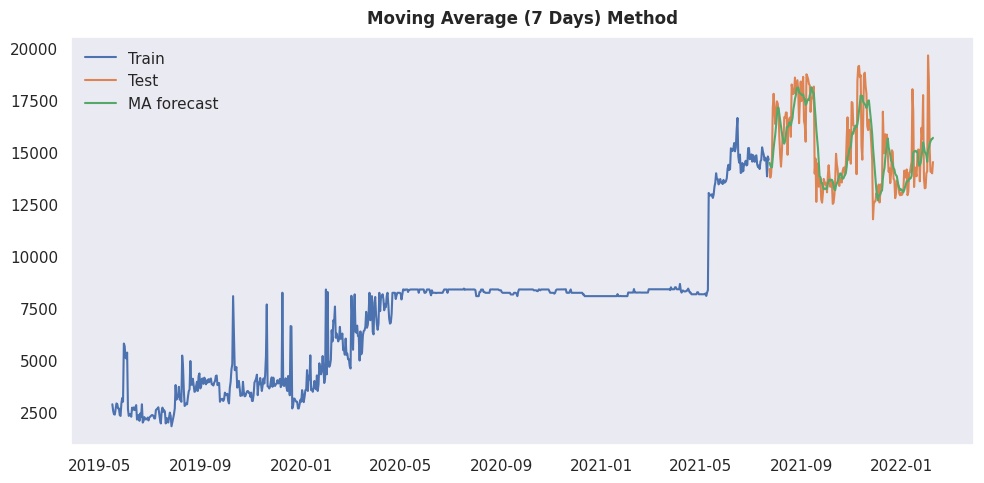

net
MAPE is  0.013421198301310326


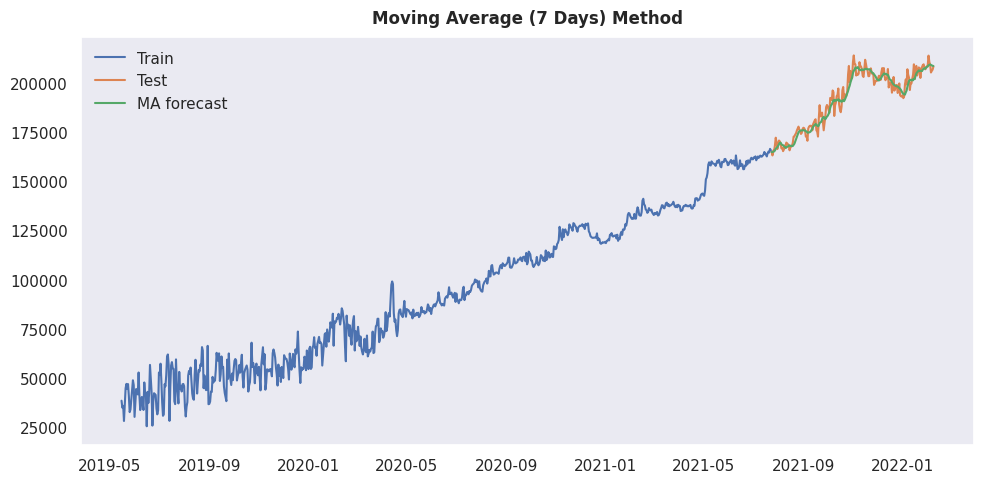

In [42]:
for i in range( 1 , len ( draft.columns )  ): # Use 1 to len ( draft.columns ) to get all region zones data or use 11,12 (AS example) to get specifc region zones
    #print(i)

    sub_df = draft.loc[:, ['usage_date', draft.columns[i]]]
    ma_forecasting(sub_df)

# End of File